# Testing Other LPs

## Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
import os
cwd = os.getcwd()
print(cwd)
nwd = os.path.join(cwd, "..", "narratives")
sys.path.insert(0, nwd)

C:\narrative-maps\tests


In [3]:
import matplotlib.pyplot as plt

In [4]:
import pydot
from IPython.display import SVG

In [5]:
from packages.solve_LP import *
from packages.graph_utils import *

## Reading Data

In [6]:
def clean_publication(graph_df):
    publication_dict = {'www.bbc.com': 'bbc',
                    'www.aljazeera.com': 'ajz',
                    'www.nytimes.com': 'nyt',
                    'www.theguardian.com': 'tgn',
                    'edition.cnn.com': 'cnn',
                    'www.cnn.com': 'cnn',
                    'Reuters': 'reu',
                    'www.reuters.com': 'reu',
                    'Business Insider': 'bin',
                    'CNN': 'cnn',
                    'The Hill': 'hill',
                    'The New York Times': 'nyt',
                    'CNBC': 'cnbc',
                    'Breitbart': 'brb',
                    'www.breitbart.com': 'brb',
                    'Fox News': 'fox',
                    'www.foxnews.com': 'fox',
                    'CIA': 'cia',
                    'FBI': 'fbi',
                    'Army CID': 'cid',
                    'INS': 'ins',
                    'Sanctioned Intercepts': 'sai',
                    'NSA': 'nsa',
                    'abcnews.go.com': 'abc',
                    'apnews.com': 'apn',
                    'www.firstpost.com': 'fpost',
                    'theconversation.com': 'tcon',
                    'nypost.com': 'nyp',
                    'newscomworld.com': 'nwc',
                    'havanatimes.org': 'hvt',
                    'www.nbcnews.com': 'nbc',
                    'www.local10.com': 'l10',
                    'www.trtworld.com': 'trt',
                    'www.washingtonpost.com': 'wapo',
                    'www.xinhuanet.com': 'xinhua'
                    }
    graph_df['publication'] = graph_df['publication'].map(publication_dict).fillna('default')
    return graph_df

In [7]:
def read_query(dataset, start_date=None, end_date=None, partial=False):
    data_file = str(dataset) + '.csv'
    data_file_path = os.path.join(cwd, "..", "data", data_file)
    if partial:
        columns_to_skip = 'embed'
        query = pd.read_csv(data_file_path, usecols=lambda x: x not in columns_to_skip)
    else:
        query = pd.read_csv(data_file_path)
    query = clean_publication(query)

    # Inferring datatime format (this might bring issues depending on the data!)
    query['date'] = pd.to_datetime(query['date'], infer_datetime_format=True) #8/22/2019 12:15

    if start_date is not None:
        query = query[(query['date'] >= pd.to_datetime(start_date, format='%Y-%m-%d'))]

    if end_date is not None:
        query = query[(query['date'] <= pd.to_datetime(end_date, format='%Y-%m-%d'))]

    if not partial:
        embed_list = ['embed']
        query[embed_list] = query[embed_list].replace(r'( )+', ',', regex=True)
        query[embed_list] = query[embed_list].replace('\[,', '[', regex=True)
        query[embed_list] = query[embed_list].replace(',]', ']', regex=True)
        query[embed_list] = query[embed_list].applymap(literal_eval).applymap(np.array)

        if 'cluster_vec' in query.columns: # Predefined clusters!
            query[['cluster_vec']] = query[['cluster_vec']].applymap(literal_eval).applymap(np.array)

    query.reset_index(inplace=True)
    query['id'] = [str(i) for i in list(query.index)]

    return query

In [8]:
dataset = "cuba"
query = read_query(dataset)
sim_table = compute_sim(query)

## Plots

In [9]:
def plot_complexity_metric(all_iterations, all_complexities, column):
    max_val_list = []
    for idx, complexity in enumerate(all_complexities):
        max_val_list.append(max(complexity[column]))
    max_val = max(max_val_list) 
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax[0].title.set_text('All runs')
    ax[0].set_xlabel('# of Iterations')
    ax[0].set_ylabel(column)
    ax[0].set_ylim(0, max_val)
    ax[1].title.set_text('Average')
    ax[1].set_xlabel('# of Iterations')
    ax[1].set_ylabel(column)
    ax[1].set_ylim(0, max_val)
    # All elements    
    for idx, complexity in enumerate(all_complexities):
        ax[0].plot(list(range(len(complexity[column]))), complexity[column], '-r')
    # Average
    max_iter = max(all_iterations)
    extended_metric_list = []
    for idx, complexity in enumerate(all_complexities):
        metric_list_extended = list(complexity[column]) + [list(complexity[column])[-1] for _ in range(max_iter - len(complexity[column]))]
        extended_metric_list.append(metric_list_extended)
    extended_metric_array = np.array(extended_metric_list)
    average_metric = np.nanmedian(extended_metric_array, axis=0)
    ax[1].plot(list(range(max_iter)), average_metric, '-r')
    
def plot_error_rate(all_iterations, all_percents):
    max_val_list = []
    for idx, percent_list in enumerate(all_percents):
        max_val_list.append(max(percent_list))
    max_val = max(max_val_list) 
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax[0].title.set_text('All runs')
    ax[0].set_xlabel('# of Iterations')
    ax[0].set_ylabel('Error Rate')
    ax[0].set_ylim(0, max_val)
    ax[1].title.set_text('Average')
    ax[1].set_xlabel('# of Iterations')
    ax[1].set_ylabel('Error Rate')
    ax[1].set_ylim(0, max_val)
    # All elements
    for idx, percent_list in enumerate(all_percents):
        ax[0].plot(list(range(all_iterations[idx])), percent_list, '-r')
    # Average
    max_iter = max(all_iterations)
    extended_percent_list = []
    for percent_list in all_percents:
        percent_list_extended = percent_list + [percent_list[-1] for _ in range(max_iter - len(percent_list))]
        extended_percent_list.append(percent_list_extended)
    extended_percent_array = np.array(extended_percent_list)
    average_percent = np.nanmedian(extended_percent_array, axis=0)
    ax[1].plot(list(range(max_iter)), average_percent, '-r')

In [10]:
def plot_all(all_iterations, all_percents, all_complexities):
    plot_error_rate(all_iterations, all_percents)
    plot_complexity_metric(all_iterations, all_complexities, column='Nodes')
    plot_complexity_metric(all_iterations, all_complexities, column='Edges')
    plot_complexity_metric(all_iterations, all_complexities, column='Stories')
    plot_complexity_metric(all_iterations, all_complexities, column='Interstory Connections')

## New Linear Program

In [11]:
def new_LP(query, sim_table, membership_vectors, clust_sim_table, exp_temp_table, ent_table, numclust, relevance_table,
    K, mincover, sigma_t, credibility=[], bias=[], operations=[],
    has_start=True, has_end=False, window_time=None, cluster_list=[], start_nodes=[], end_nodes=[],
    verbose=True, force_cluster=True, previous_varsdict=None):
    
    n = len(query.index) #We can cut out everything after the end.
    # Variable names and indices
    var_i = []
    var_ij = []
    var_k = [str(k) for k in range(0,numclust)]

    for i in range(0, n): # This goes up from 0 to n-1.
        var_i.append(str(i))
        for j in window_i_j[i]:
            if i == j:
                print("ERROR IN WINDOW - BASE")
            var_ij.append(str(i) + "_" + str(j))

    potential_edges = n * (n - 1) / 2
    
    # Linear program variable declaration.
    minedge = LpVariable("minedge", lowBound = 0, upBound = 1)
    node_act_vars = LpVariable.dicts("node_act", var_i, lowBound = 0, upBound = 1)
    node_next_vars = LpVariable.dicts("node_next", var_ij, lowBound = 0,  upBound = 1)
    clust_active_vars = LpVariable.dicts("clust_active", var_k, lowBound = 0, upBound = 1)

    # Create the 'prob' variable to contain the problem data
    prob = LpProblem("StoryChainProblem", LpMaximize)
    # The objective function is added to 'prob' first
    prob += minedge * potential_edges - lpSum([node_next_vars[ij] for ij in var_ij]), "WeakestLink"

    # Check duplicates in interactions
    replace = [False] * len(operations)
    for idx, op in enumerate(operations):
        op_ref = op.split(":",1)[1]
        for k in range(idx):
            if op_ref == operations[k].split(":",1)[1]:
                replace[k] = True
    # Fixtures.
    min_threshold_edge = 0.1 / K
    min_threshold_node = 0.4 / K
    for idx, op in enumerate(operations):
        op_ref = op.split(":",1)[1]
        # Omit ACL in this part, handle separetely.
        if "ACL" in op:
            continue

        temp = ""
        if "-" in op_ref:
            i = int(op_ref.split("-",1)[0])
            j = int(op_ref.split("-",1)[1])
            temp = str(i) + "_" + str(j)
        else:
            i = int(op_ref)
            temp = str(i)
        op_ref = temp

        if "AN" in op:
            if verbose:
                print('AddedNode ' + str(op_ref))
            if not replace[idx]:
                if prob.constraints.get('RemovedNode' + str(op_ref)) is not None:
                    del prob.constraints['RemovedNode' + str(op_ref)]
                prob += node_act_vars[str(op_ref)] >= min_threshold_node, 'AddedNode' + str(op_ref) # Makes problem infeasible if we add too many, divide threhsold by K? By number of added constraints?
        elif "AE" in op:
            if verbose:
                print('AddedEdge ' + str(op_ref))
            if not replace[idx]:
                if prob.constraints.get('RemovedEdge' + str(op_ref)) is not None:
                    del prob.constraints['RemovedEdge' + str(op_ref)]
                if str(op_ref) not in node_next_vars.keys():
                    # Special case for time-based windows where the time difference is too big.
                    # The connection does not exist by default and you need to add the variable manually for the specific edge.
                    node_next_vars[str(op_ref)] = LpVariable("node_next_" + str(op_ref), lowBound=0, upBound=1)
                    if i == j:
                        print("ERROR IN WINDOW - AE")
                    var_ij.append(str(op_ref))#str(i) + "_" + str(j))
                    window_i_j[i].append(j)
                    window_j_i[j].append(i)
                prob += node_next_vars[str(op_ref)] >= min_threshold_edge, 'AddedEdge' + str(op_ref)
        elif "RN" in op:
            if verbose:
                print('RemovedNode ' + str(op_ref))
            if not replace[idx]:
                if prob.constraints.get('AddedNode' + str(op_ref)) is not None:
                    del prob.constraints['AddedNode' + str(op_ref)]
                if prob.constraints.get('AddedNodeCluster' + str(op_ref)) is not None:
                    del prob.constraints['AddedNodeCluster' + str(op_ref)]
                prob += node_act_vars[str(op_ref)] == 0, 'RemovedNode' + str(op_ref)
        elif "RE" in op:
            if verbose:
                print('RemovedEdge ' + str(op_ref))
            if not replace[idx]:
                if prob.constraints.get('AddedEdge' + str(op_ref)) is not None:
                    del prob.constraints['AddedEdge' + str(op_ref)]
                prob += node_next_vars[str(op_ref)] == 0, 'RemovedEdge' + str(op_ref)

    if force_cluster:
        #min_threshold_edge = 0.1 / K
        #min_threshold_node = 0.4 / K
        min_threshold_edge = 0.05
        min_threshold_node = 0.01
        for cluster in cluster_list:
            cluster_sorted = sorted(cluster)
            #print("Cluster:")
            #print(cluster_sorted)
            for idx, event in enumerate(cluster_sorted):
                if verbose:
                    print('AddedNodeCluster ' + str(event))
                if prob.constraints.get('RemovedNode' + str(event)) is not None:
                    del prob.constraints['RemovedNode' + str(event)]
                if prob.constraints.get('AddedNodeCluster' + str(event)) is not None:
                    del prob.constraints['AddedNodeCluster' + str(event)]

                prob += node_act_vars[str(event)] >= min_threshold_node, 'AddedNodeCluster' + str(event)
                #print("Filtered cluster " + str(cluster_sorted[(idx + 1):]))
                if len(cluster_sorted[(idx + 1):]) >= 1:
                    for j in cluster_sorted[(idx + 1):]:
                        op_ref = str(event) + "_" + str(j)
                        #print("Forced connections: " + str(op_ref))
                        if str(op_ref) not in node_next_vars.keys():
                            # Special case for time-based windows where the time difference is too big.
                            # The connection does not exist by default and you need to add the variable manually for the specific edge.
                            if event == j:
                                print("ERROR IN WINDOW - ACL")
                            node_next_vars[str(op_ref)] = LpVariable("node_next_" + str(op_ref), lowBound=0, upBound=1)
                            var_ij.append(str(op_ref))
                            window_i_j[event].append(j)
                            window_j_i[j].append(event)
                            #print(window_i_j[i])
                            #print(window_j_i[i])
                    prob += lpSum([node_next_vars[str(event) + "_" + str(j)] for j in cluster_sorted[(idx + 1):]]) >= min_threshold_edge, 'InternalEdgeCluster' + str(event)
                    if verbose:
                        print('InternalEdgeCluster' + str(event) + ":" + str(cluster_sorted[(idx + 1):]))
    #for combination in itertools.combinations(cluster_list,2):
    #    for node_i in combination[0]:
    #        for node_j in combination[1]:
    #            if int(node_i) < int(node_j):
    #                prob += node_act_vars[str(op_ref)] >= min_threshold_node, 'AddedNode' + str(op_ref)

    # Chain restrictions
    if has_start:
        num_starts = len(start_nodes)
        if verbose:
            print("Start node(s):")
            print(start_nodes)
        if num_starts == 0: # This is the default when no list is given and it has a start.
            prob += node_act_vars[str(0)] == 1, 'InitialNode'
        else:
            if verbose:
                print("Added start node(s)")
                print("--- %s seconds ---" % (time() - start_time))
            initial_energy = 1.0 / num_starts
            earliest_start = min(start_nodes)
            for node in start_nodes:
                prob += node_act_vars[str(node)] == initial_energy, 'InitialNode' + str(node)
            for node in range(0, earliest_start):
                prob += node_act_vars[str(node)] == 0, 'BeforeStart' + str(node)
    if has_end:
        num_ends = len(end_nodes)
        if verbose:
            print("End node(s):")
            print(end_nodes)
        if num_ends == 0: # This is the default when no list is given and it has a start.
            prob += node_act_vars[str(n - 1)] == 1, 'FinalNode'
        else:
            if verbose:
                print("Added end node(s)")
                print("--- %s seconds ---" % (time() - start_time))
            final_energy = 1.0 / num_ends
            latest_end = min(end_nodes)
            for node in end_nodes:
                prob += node_act_vars[str(node)] == final_energy, 'FinalNode' + str(node)
            for node in range(latest_end + 1, n):
                prob += node_act_vars[str(node)] == 0, 'AfterEnd' + str(node)

    if verbose:
        print("Chain constraints created.")
        print("--- %s seconds ---" % (time() - start_time))
    prob += lpSum([node_act_vars[i] for i in var_i]) == K, 'KNodes'
    
    if verbose:
        print("Expected length constraints created.")
        print("--- %s seconds ---" % (time() - start_time))


    if has_start:
        if verbose:
            print("Equality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for j in range(1, n):
            if j not in start_nodes:
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for i in window_j_i[j]]) == node_act_vars[str(j)], 'InEdgeReq' + str(j)
            else:
                if verbose:
                    print("Generating specific starting node constraints.")
                    print("--- %s seconds ---" % (time() - start_time))
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for i in window_j_i[j]]) == 0, 'InEdgeReq' + str(j)
    else:
        if verbose:
            print("Inequality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for j in range(1, n):
            prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for i in window_j_i[j]]) <= node_act_vars[str(j)], 'InEdgeReq' + str(j)
    if verbose:
        print("In-degree constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    if has_end:
        if verbose:
            print("Equality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for i in range(0, n - 1):
            if i not in end_nodes:
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for j in window_i_j[i]]) == node_act_vars[str(i)], 'OutEdgeReq'  + str(i)
            else:
                if verbose:
                    print("Generating specific starting node constraints.")
                    print("--- %s seconds ---" % (time() - start_time))
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for j in window_i_j[i]]) == 0, 'OutEdgeReq'  + str(i)
    else:
        if verbose:
            print("Inequality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for i in range(0, n - 1):
            prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for j in window_i_j[i]]) <= node_act_vars[str(i)], 'OutEdgeReq'  + str(i)
    if verbose:
        print("Out-degree constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    # Coverage
    if numclust > 1:
        prob += lpSum([clust_active_vars[str(k)] for k in var_k]) >= numclust * mincover, "MinCover"
        for k in range(0, numclust):
            prob += clust_active_vars[str(k)] == lpSum([node_next_vars[str(i) + "_" + str(j)] * sqrt(membership_vectors[i, k] * membership_vectors[j, k]) for i in range(0, n - 1) for j in window_i_j[i]]), "CoverDef" + str(k)
        if verbose:
            print("Clustering constraints created.")
            print("--- %s seconds ---" % (time() - start_time))
    else:
        if verbose:
            print("No clustering constraints created - only 1 cluster.")
            print("--- %s seconds ---" % (time() - start_time))

    # Objective
    for i in range(0, n):
        for j in window_i_j[i]:
            coherence_weights = [0.5, 0.5]
            entity_multiplier = min(1 + ent_table[i, j], 2) # Five or more entities in common means double the connection strength.
            relevance_multiplier = (relevance_table[i] * relevance_table[j]) ** 0.5 # Geometric mean the relevances, multiply based on how far it is from 0.5.
            coherence = (sim_table[i, j] ** coherence_weights[0]) * (clust_sim_table[i, j] ** coherence_weights[1])
            weighted_coherence = min(coherence * entity_multiplier * relevance_multiplier, 1.0)
            prob += minedge <= 1 - node_next_vars[str(i) + "_" + str(j)] + weighted_coherence, "Objective" + str(i) + "_" + str(j)
    if verbose:
        print("Objective constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    if previous_varsdict:
        current_names = [v.name for v in prob.variables() if "node_act" in v.name]
        if verbose:
            print("Generated list of names.")
            print("--- %s seconds ---" % (time() - start_time))
        for k, v in previous_varsdict.items():
            if "node_act" in k and k in current_names:
                node_act_vars[k.replace("node_act_", "")].setInitialValue(v)

    if verbose:
        if previous_varsdict:
            print("Used previous solution as starting point.")
            print("--- %s seconds ---" % (time() - start_time))
        else:
            print("No previous solution available.")
            print("--- %s seconds ---" % (time() - start_time))
    # The problem data is written to an .lp file
    return prob

## LP Preprocessing

In [12]:
def solve_LP_from_query(query, dataset,
    operations=[], K = 6, mincover=0.20,
    min_samples=2, min_cluster_size=2,
    n_neighbors=2, min_dist=0.01,
    sigma_t = 30,
    start_nodes=[], end_nodes=[],
    verbose=True, random_state=42,
    force_cluster=True,
    use_entities=True, use_temporal=True, strict_start=False, umap_init='spectral', cosine_sim = True, use_new_LP=False):

    global start_time
    start_time = time()
    # Min-cluster-size = 10, n_neighbors=2
    doc_list = []
    for index, article in query.iterrows():
        doc_list.append(article['embed'])
    X = np.array(doc_list)

    # Find cluster list
    cluster_dict = {}
    for idx, op in enumerate(operations):
        if "ACL" in op:
            op_ref = op.split(":",1)[1]
            # Remove _out (this case only happens if you mark a story node before adding it to the map.)
            node_set = set([int(node.replace('_out', '')) for node in literal_eval(op_ref.split("-",1)[0])])
            cluster_id = int(op_ref.split("-",1)[1])
            if cluster_id not in cluster_dict:
                cluster_dict[cluster_id] = node_set
            else:
                for key, value in cluster_dict.items():
                    if key != cluster_id:
                        cluster_dict[key] = cluster_dict[key].difference(node_set) # Make sure we only keep the latest interaction.
                cluster_dict[cluster_id] = cluster_dict[cluster_id].union(node_set)
    cluster_list = []
    for key, value in cluster_dict.items():
        cluster_list.append([int(node) for node in value])
    if verbose:
        print("Cluster List (base) " + str(cluster_list))

    clusterable_embedding = umap.UMAP(n_neighbors=n_neighbors,  min_dist=min_dist, init=umap_init, random_state=np.random.RandomState(random_state)).fit_transform(X)
    
    if len(cluster_list) > 0:
        target = -np.ones(X.shape[0])
        for clust_idx, cluster in enumerate(cluster_list):
            target[cluster] = clust_idx
        clusterable_embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, init=umap_init, random_state=np.random.RandomState(random_state)).fit_transform(X, y=target)
    if verbose:
        print("Computed projection.")
        print("--- %s seconds ---" % (time() - start_time))

    if cosine_sim:
        similarities = np.clip(cosine_similarity(clusterable_embedding), -1 , 1)
        # Force normalize
        sim_table = (1 - np.arccos(similarities) / pi)
        mask = np.ones(sim_table.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        max_value = sim_table[mask].max()
        min_value = sim_table[mask].min()
        sim_table = (sim_table - min_value) / (max_value - min_value)
        sim_table = np.clip(sim_table, 0, 1)
    else:
        dist_mat = distance.cdist(clusterable_embedding, clusterable_embedding, 'euclidean')

        mask = np.ones(dist_mat.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        max_value = dist_mat[mask].max()
        min_value = dist_mat[mask].min()
        dist_mat = (dist_mat - min_value)/(max_value - min_value)
        sim_table = np.clip(1 - dist_mat, -1, 1)
    if verbose:
        print("Computed similarities.")
        print("--- %s seconds ---" % (time() - start_time))


    hdbscan_model = hdbscan.HDBSCAN(min_samples=min_samples,min_cluster_size=min_cluster_size,prediction_data=True)
    labels = hdbscan_model.fit_predict(clusterable_embedding)
    membership_vectors = hdbscan.prediction.all_points_membership_vectors(hdbscan_model)
    numclust = 1
    clust_sim = np.zeros((membership_vectors.shape[0], membership_vectors.shape[0]))
    if verbose:
        print("Computed clustering.")
        print("--- %s seconds ---" % (time() - start_time))

    if len(membership_vectors.shape) > 1:
        numclust = membership_vectors.shape[1]
        membership_vectors[membership_vectors < 1/numclust] = 0
        #np.set_printoptions(threshold=sys.maxsize)
        # If any row is full of zeros replace with uniform distribution.
        membership_vectors[np.all(membership_vectors == 0, axis=1)] = np.ones(numclust) / numclust
        row_sums = membership_vectors.sum(axis=1)
        membership_vectors = membership_vectors / row_sums[:, np.newaxis]
        clust_sim = distance.cdist(membership_vectors, membership_vectors, lambda u,v:distance.jensenshannon(u,v,base=2.0))
    else:
        membership_vectors = np.ones((membership_vectors.shape[0], 1)) # No clusters special case (all noise according to HDBSCAN)

    clust_sim_table = 1 - clust_sim
    if verbose:
        print("Computed clustering similarities.")
        print("--- %s seconds ---" % (time() - start_time))

    n = len(query.index)
    # Compute temporal distances

    varsdict_filename = 'varsdict_' + dataset  + "_" + str(n) + '.pickle'

    temporal_distance_table = compute_temp_distance_table(query, dataset)

    if sigma_t != 0 and use_temporal:
        exp_temp_table = np.exp(-temporal_distance_table / sigma_t)
    else:
        exp_temp_table = np.ones(temporal_distance_table.shape)

    if verbose:
        print("Computed temporal distance table.")
        print("--- %s seconds ---" % (time() - start_time))

    window_time = None
    if sigma_t != 0 and use_temporal:
        window_time = sigma_t * 3 # Days

    if window_time is None:
        for i in range(0, n):
            window_i_j[i] = list(range(i + 1, n))
        for j in range(0, n):
            window_j_i[j] = list(range(0, j))
    else:
        for j in range(0, n):
            window_j_i[j] = []
        for i in range(0, n):
            window_i_j[i] = []
        for i in range(0, n - 1):
            window = 0
            for j in range(i + 1, n):
                if temporal_distance_table[i,j] <= window_time:
                    window += 1
            window = max(min(5, n - i), window)
            window_i_j[i] = list(range(i + 1, min(i + window, n)))
            for j in window_i_j[i]:
                window_j_i[j].append(i)

    if verbose:
        print("Computed temporal windows.")
        print("--- %s seconds ---" % (time() - start_time))

    ent_table, ent_doc_list = get_entity_table(query, dataset)
    if verbose:
        print("Computed entity similarities.")
        print("--- %s seconds ---" % (time() - start_time))
    if not use_entities:
        ent_table = np.zeros(ent_table.shape)

    # Deprecated relevance table computation
    relevance_table = [1.0] * membership_vectors.shape[0] # Create a vector full of 1s
    focus_query = None
    if focus_query: # Uses focus_query (string)
        #torch.cuda.empty_cache()
        model = SentenceTransformer('all-MiniLM-L6-v2')
        q = model.encode(focus_query)
        q = q.reshape(1, -1)
        euc_dist = distance.cdist(q, X, metric='euclidean')
        euc_dist = (euc_dist - np.min(euc_dist)) / (np.max(euc_dist) - np.min(euc_dist))
        sim_list = 1 - euc_dist
        relevance_table = sim_list[0] # Remove one dimension.
        if verbose:
            print("Computed query relevance table.")
            print("--- %s seconds ---" % (time() - start_time))

    has_start = False
    if start_nodes is not None:
        has_start = (len(start_nodes) > 0)
    if end_nodes is not None:
        has_end = (len(end_nodes) > 0)
    if verbose:
        print("Creating LP...")

    # Read previous solution and feed to LP. If none there is no previous solution.
    previous_varsdict = None
    if os.path.isfile(varsdict_filename):
        with open(varsdict_filename, 'rb') as handle:
            previous_varsdict = pickle.load(handle)
    if use_new_LP:
        prob = new_LP(query, sim_table, membership_vectors, clust_sim_table, exp_temp_table, ent_table, numclust, relevance_table,
            K=K, mincover=mincover, sigma_t=sigma_t,
            operations=operations, cluster_list=cluster_list,
            has_start=has_start, has_end=has_end,
            start_nodes=start_nodes, end_nodes=end_nodes, verbose=verbose, force_cluster=force_cluster)
    else:
        prob = create_LP(query, sim_table, membership_vectors, clust_sim_table, exp_temp_table, ent_table, numclust, relevance_table,
            K=K, mincover=mincover, sigma_t=sigma_t,
            operations=operations, cluster_list=cluster_list,
            has_start=has_start, has_end=has_end,
            start_nodes=start_nodes, end_nodes=end_nodes, verbose=verbose, force_cluster=force_cluster)
    if verbose:
        print("Saving model...")
        print("--- %s seconds ---" % (time() - start_time))
    prob.writeLP("left_story.lp")
    if verbose:
        print("Solving model...")
        print("--- %s seconds ---" % (time() - start_time))
    prob.solve(PULP_CBC_CMD(mip=False, warmStart=True))#(GLPK_CMD(path = 'C:\\glpk-4.65\\w64\\glpsol.exe', options = ["--tmlim", "180"]))


    varsdict = extract_varsdict(prob)
    # Overwrite last solution.
    with open(varsdict_filename, 'wb') as handle:
        pickle.dump(varsdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    graph_df = build_graph_df_multiple_starts(query, varsdict, prune=ceil(sqrt(K)), threshold=0.1/K, cluster_dict=cluster_dict)
    #graph_df = build_graph_df_multiple_starts(query, varsdict, prune=None, threshold=0.0/K, cluster_dict=cluster_dict)

    if verbose:
        print("Graph data frame construction...")
        print("--- %s seconds ---" % (time() - start_time))

    if strict_start:
        graph_df = graph_clean_up(graph_df, start_nodes)

    if verbose:
        print("Graph clean up...")
        print("--- %s seconds ---" % (time() - start_time))

    cluster_assignment = np.argmax(membership_vectors, axis=1)
    scatter_df = pd.DataFrame(data=clusterable_embedding, columns=['X', 'Y'])
    scatter_df['id'] = query['id']
    scatter_df['cluster_id'] = cluster_assignment
    scatter_df['cluster_id'] = scatter_df['cluster_id'].astype(str)
    scatter_df['title'] = query['title']

    if verbose:
        print("Scatter data frame construction...")
        print("--- %s seconds ---" % (time() - start_time))

    return [graph_df, (numclust, LpStatus[prob.status]), scatter_df, sim_table, clust_sim_table, ent_table, ent_doc_list, cluster_assignment]

## LP Wrapper

In [13]:
def generate_map(query, dataset, previous_actions=[], k_input=8, mincover_input=20, window=30, start_nodes=[], 
                 verbose=True, random_state=42, force_cluster=False, use_temporal=True, use_entities=False, use_new_LP=False):
    operation_list = []
    for item in previous_actions:
        if item.get("action") == "add-node":
            for node in item['content']:
                operation_list.append("AN:" + node)
        elif item.get("action") == "add-edge":
             operation_list.append("AE:" + item["content"])
        elif item.get("action") == "remove-node":
            for node in item['content']:
                operation_list.append("RN:" + node)
        elif item.get("action") == "remove-edge":
            for edge in item['content']:
                operation_list.append("RE:" + edge)
        elif item.get("action") == "add-cluster-list":
             operation_list.append("ACL:" + str(item['content'][0]) + "-" + str(item['content'][1]))
    
    # Solve LP and create new graph_df.
    cluster_size_est = np.sqrt(len(query.index))/2
    cluster_size_est = 5 * round(cluster_size_est / 5) # Round to nearest multiple of 5
    n_neighbors = 2
    if len(query.index) > 40:
        n_neighbors = 10
    elif len(query.index) > 120:
        n_neighbors = cluster_size_est

    graph_df_new, status, scatter_df, sim_table, clust_sim_table, ent_table, ent_doc_list, cluster_assignment = solve_LP_from_query(query, 
        dataset=dataset, operations=operation_list, 
        K=k_input, mincover=mincover_input/100, 
        min_samples=2, min_cluster_size=cluster_size_est, n_neighbors=n_neighbors, min_dist=1/100,
        start_nodes=start_nodes, verbose=verbose, random_state=random_state, force_cluster=force_cluster,
        use_temporal=use_temporal, use_entities=use_entities, use_new_LP=use_new_LP)        

    status_msg = "LP Status: " + status[1] + ", Clusters: " + str(status[0])

    if 'Optimal' in status[1]:
        # Generate graph from LP solution.
        G = build_graph(graph_df_new)
        storylines = graph_stories(G, start_nodes=start_nodes, end_nodes=[])
        status_msg += ", Storylines: " + str(len(storylines))

        # We now apply transitive reduction.
        remove_list_transitive = []
        for story in storylines:
            max_idx = len(story) - 1
            for idx, node in enumerate(story):
                out_edges = G.out_edges(node)
                # If it's not the last element in the story (no need to clean the last one, because there are no in-story outgoing edges)
                if idx != max_idx:
                    for edge in out_edges:
                        if edge[1] in story and edge[1] != story[idx + 1]: # If it's an in-story edge and not the immediately adjacent one.
                            remove_list_transitive.append(edge)
        G.remove_edges_from(remove_list_transitive)
        # We now filter redundant interstory connections.
        remove_list_interstory = []
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            keep_set = set()
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            if len(edge_boundary_list_i) > 0:
                earliest_i = min(edge_boundary_list_i, key = lambda t: (t[0], t[1]))
                latest_i = max(edge_boundary_list_i, key = lambda t: (t[0], t[1]))
            else:
                earliest_i = None
            if len(edge_boundary_list_j) > 0:
                earliest_j = min(edge_boundary_list_j, key = lambda t: (t[1], t[0]))
                latest_j = max(edge_boundary_list_j, key = lambda t: (t[1], t[0]))
            else:
                earliest_j = None
            if not earliest_i and not earliest_j:
                # No connections
                continue
            elif earliest_i and not earliest_j:
                # One-sided.
                if earliest_i == latest_i: # There's only one connection, keep it.
                    continue
                elif earliest_i[0] == latest_i[0]:
                    # This means that the second values are different, but the first one is the same.
                    # For this special case we keep the earliest one.
                    keep_set.add(earliest_i)
                else:
                    # Keep both
                    keep_set.add(earliest_i)
                    keep_set.add(latest_i)
            elif not earliest_i and earliest_j:
                # One-sided and reversed.
                if earliest_j == latest_j: # There's only one connection, keep it.
                    continue
                elif earliest_j[1] == latest_j[1]:
                    # This means that the first values are different, but the second one is the same.
                    # For this special case we keep the earliest one.
                    keep_set.add(earliest_j)
                else:
                    # Keep both
                    keep_set.add(earliest_j)
                    keep_set.add(latest_j)
            else:
                # Two-sided.
                if earliest_i[0] < earliest_j[1]:
                    # E_i happened first. Keep it
                    keep_set.add(earliest_i)
                    if latest_i[0] > latest_j[1]:
                        # L_i happened last. Keep it.
                        keep_set.add(latest_i)
                    else:
                        keep_set.add(latest_j)
                else:
                    # E_j happened first.
                    keep_set.add(earliest_j)
                    if latest_i[0] > latest_j[1]:
                        # E_i happened last. Keep it.
                        keep_set.add(latest_i)
                    else:
                        keep_set.add(latest_j)
            redundant_edge_set = set(edge_boundary_list_i) | set(edge_boundary_list_j)
            remove_list_interstory += list(redundant_edge_set - keep_set)

        G.remove_edges_from(remove_list_interstory)

        for node in G.nodes:
            sum_node = sum([exp(-data['weight']) for u, v, data in G.out_edges(node, data=True)])
            if sum_node == 0:
                continue
            for u, v, data in G.out_edges(node, data=True):
                G[u][v]['weight'] = -log(exp(-data['weight']) / sum_node)
            sum_node = sum([exp(-G[u][v]['weight']) for u, v, data in G.out_edges(node, data=True)])
        # Update graph_df
        for i, row in graph_df_new.iterrows():
            new_adj_list = [v for u, v in G.out_edges(str(row['id']))]
            new_adj_weights = [exp(-G[u][v]['weight']) for u, v in G.out_edges(str(row['id']))]
            graph_df_new.at[i,'adj_list'] = new_adj_list
            graph_df_new.at[i,'adj_weights'] = new_adj_weights

        for node in G.nodes:  
            sum_node = sum([exp(-data['weight']) for u, v, data in G.out_edges(node, data=True)])
            if sum_node == 0:
                continue
            for u, v, data in G.out_edges(node, data=True):
                G[u][v]['weight'] = -log(exp(-data['weight']) / sum_node)
            sum_node = sum([exp(-data['weight']) for u, v, data in G.out_edges(node, data=True)])

        # Update graph_df
        for i, row in graph_df_new.iterrows():
            new_adj_list = [v for u, v in G.out_edges(str(row['id']))]
            new_adj_weights = [exp(-G[u][v]['weight']) for u, v in G.out_edges(str(row['id']))]
            graph_df_new.at[i,'adj_list'] = new_adj_list
            graph_df_new.at[i,'adj_weights'] = new_adj_weights
            
        #print(graph_df_new)
        return G, graph_df_new, storylines

## GraphViz

In [14]:
def is_path_edge(i, j, val_list):
    k = 0
    while int(val_list[k]) <= int(i):
        if int(val_list[k]) == int(i) and int(val_list[k+1]) == int(j):
            return True
        k += 1
        if k >= len(val_list):
            return False
    return False

In [15]:
def graph_viz_gen(graph_df, sp, full=False, antichains=None):
    col_pol = {'FL': "#021893", 'LL': "#3537ae", 'CM': "#740699", 'LR': "#b70b0b", 'FR': "#990623"}
    transparency = "60" #80 is 50%
    graph_viz_clean = None
    start = int(sp[0])
    end = int(sp[-1])

    graph_viz = "digraph Story { \n" 
    graph_viz += "graph [fontname = \"candara\"];\n"
    graph_viz += "node [shape=none, margin=0, fontname = \"candara\"];\n"
    graph_viz += "edge [fontname = \"calibri light\"];\n"
        
    if antichains is not None:
        graph_viz += "subgraph cluster_antichain { \n"
        graph_viz += "style=filled; color=lightgray; label =<<b>Max Antichain</b>>; labeljust=\"l\"; \n"
        for idx in antichains:
            row = graph_df.loc[graph_df['index'] == idx]
            node_label = '<table><tr><td><b>' + row['publication'].values[0] + '</b></td><td>' + row['date'].values[0] + '</td></tr><tr><td colspan="2">' + row['title'].values[0].replace("\"", "'") + '</td></tr></table>'
            #node_label = "{" + "{" + row['publication'].values[0] + "|" + row['date'].values[0] + "}" + "| " + row['title'].values[0].replace("\"", "'") + "}"
            color = "style=filled, fillcolor=\"" + col_pol['LL'] + transparency + "\""
            color += ", color=black"
            url = row['url'].values[0]
            if pd.isna(url):
                href = "href=\"#\""
            else:
                href = "href=\"" + url + "\""
            tooltip = "tooltip=\"" + row['title'].values[0].replace("\"", "'") + "\""
            #graph_viz += "\"" + str(idx) + "\"" + " [label=\"" + node_label + "\", " + color + "] \n"
            graph_viz += "\"" + str(idx) + "\"" + " [label=<" + node_label + ">, " + color + "," + href + "," + tooltip + "] \n"
        graph_viz += "} \n"
    for index, row in graph_df.iterrows():
        if antichains is not None:
            if row['id'] not in antichains:
                if row['id'] == end or row['id'] == start:
                    node_label = '<table BORDER="2" CELLSPACING="0"><tr><td><b>' + row['publication'] + '</b></td><td>' + row['date'] + '</td></tr><tr><td colspan="2">' + row['title'].replace("\"", "'") + '</td></tr></table>'
                else:
                    node_label = '<table BORDER="0" CELLBORDER="1" CELLSPACING="0"><tr><td><b>' + row['publication'] + '</b></td><td>' + row['date'] + '</td></tr><tr><td colspan="2">' + row['title'].replace("\"", "'") + '</td></tr></table>'
                color = "style=filled, fillcolor=\"" +  col_pol['LL'] + transparency + "\""
                url = row['url']
                if pd.isna(url):
                    href = "href=\"#\""
                else:
                    href = "href=\"" + url + "\""
                tooltip = "tooltip=\"" + row['title'].replace("\"", "'") + "\""
                graph_viz += "\"" + str(row['id']) + "\"" + " [label=<" + node_label + ">, " + color + "," + href + "," + tooltip + "] \n"
        else:
            if row['id'] == end or row['id'] == start:
                node_label = '<table BORDER="2" CELLSPACING="0"><tr><td><b>' + row['publication'] + '</b></td><td>' + row['date'] + '</td></tr><tr><td colspan="2">' + row['title'].replace("\"", "'") + '</td></tr></table>'
                #node_label = "{" + "{" + row['publication'] + "|" + row['date'] + "}" + "| " + row['title'].replace("\"", "'") + "}"
            else:
                node_label = '<table BORDER="0" CELLBORDER="1" CELLSPACING="0"><tr><td><b>' + row['publication'] + '</b></td><td>' + row['date'] + '</td></tr><tr><td colspan="2">' + row['title'].replace("\"", "'") + '</td></tr></table>'
           
            color = "style=filled, fillcolor=\"" +  col_pol['LL'] + transparency + "\""
            url = row['url']
            if pd.isna(url):
                href = "href=\"#\""
            else:
                href = "href=\"" + url + "\""
            tooltip = "tooltip=\"" + row['title'].replace("\"", "'") + "\""
            graph_viz += "\"" + str(row['id']) + "\"" + " [label=<" + node_label + ">, " + color + "," + href + "," + tooltip + "] \n"
               
        # Edges are always added, regardless of previous status.
        for idx, adj in enumerate(row['adj_list']):
            if is_path_edge(row['id'], adj, sp):
                edge_label = "[ label=\"" + str(round(row['adj_weights'][idx],3)) + "\",penwidth=4]"
            else:
                edge_label = "[ label=\"" + str(round(row['adj_weights'][idx],3)) + "\" ]"
            graph_viz += "\"" + str(row['id']) + "\"" + "->" + "\"" + str(adj) + "\"" + edge_label + " \n"

    graph_viz_clean = graph_viz + "}"
        
    return graph_viz_clean

## Solve map (newLP)

In [16]:
G, graph_df, storylines = generate_map(query, dataset, start_nodes=[124], previous_actions=[], verbose=False, random_state=42, use_new_LP=True)

In [17]:
graph_df['date'] = graph_df['date'].apply(lambda x: x.strftime("%m/%d/%Y"))

## Generate Viz

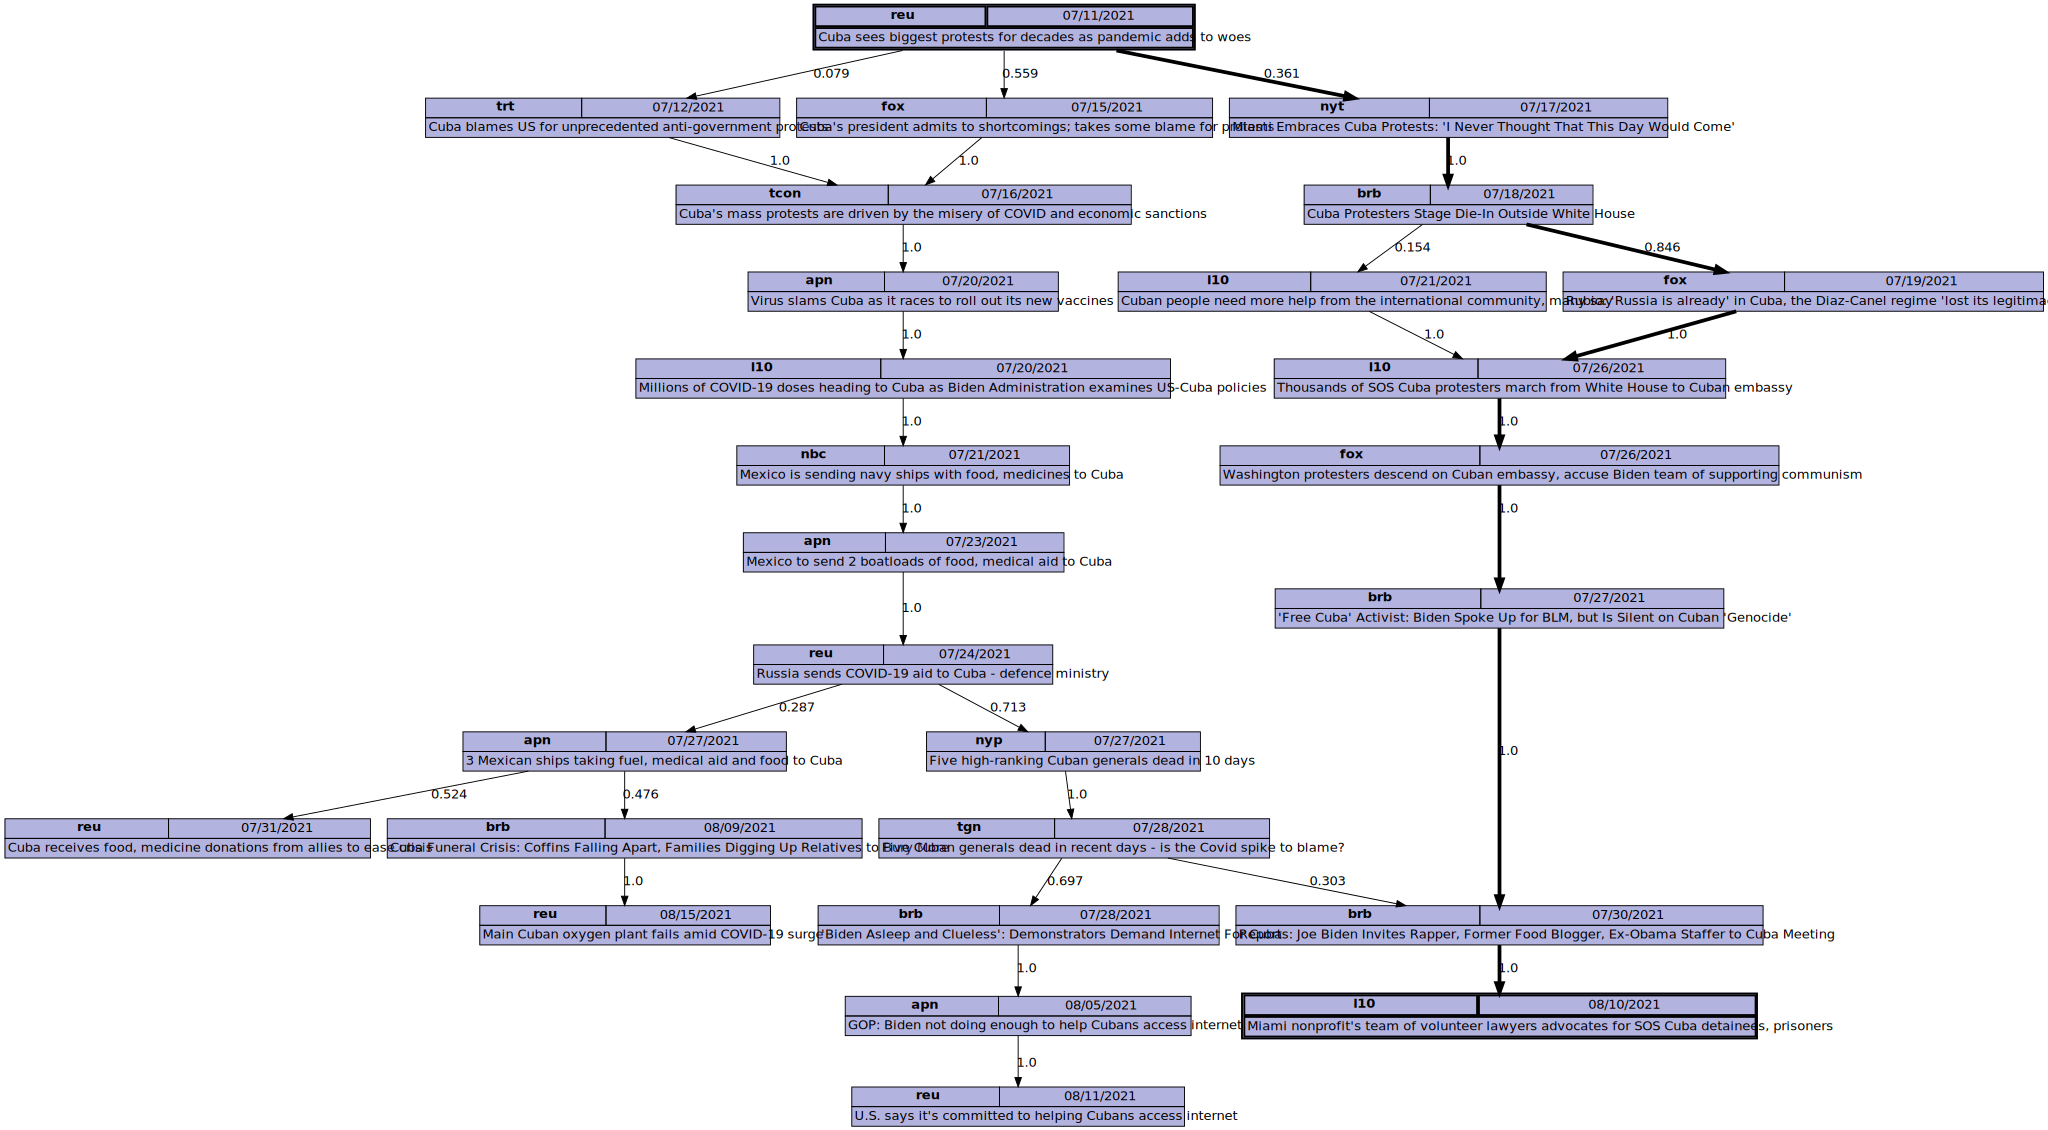

In [18]:
dot_source = graph_viz_gen(graph_df, sp=storylines[0])
text_file = open("test.js", "w")
temp_js = dot_source.replace("C:/Users/brian/Desktop/StoryChains", "./")
n = text_file.write("dotSrc = `" + temp_js + "`")
text_file.close()
    
graphs = pydot.graph_from_dot_data(dot_source)
svg_string = graphs[0].create_svg()
graphs[0].write_svg('test.svg')  
svg_string = svg_string.replace(b"C:/Users/brian/Desktop/StoryChains/", b"")
svg_cut = svg_string.replace(b'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\r\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\r\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\r\n<!-- Generated by graphviz version 2.38.0 (20140413.2041)\r\n -->\r\n<!-- Title: Story Pages: 1 -->\r\n',b'')
svg_cut = svg_string.replace(b'<a xlink:href',b'<a target="_blank" xlink:href')
html_string = b"""<div><style>path:hover{stroke-width:5;stroke:green;transition:0.3s}
            a:hover polygon {
            transition:1.0s;
            fill: #606060!important;
            fill-opacity: 0.2!important;
            opacity: 1.0!important;
            stroke: #646464;
            stroke-width: 1px;
            stroke-linejoin: round;
            }</style></div><div>""" + svg_cut + b"</div>"
with open('test.html', 'wb') as f:
    f.write(html_string)
display(SVG(svg_string))

In [19]:
# Complexity metrics
n_nodes = G.number_of_nodes()# Number of nodes
n_edges = G.number_of_edges()# Number of edges
n_stories = len(storylines)# Number of storylines
n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
total_interstory = 0
for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
    edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
    edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
    total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
# Number of inter-story connections 
complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
print("Complexity: " + str(complexity_list))

Complexity: [27, 29, 6, 4, 2, 8]


## Simulation (new LP)

In [20]:
base_total_samples = 10

## Remove Nodes
### Removing Nodes from Map (Right-leaning articles only)
Goal: Remove right-biased news articles from the map. We fix a center starting point from Reuters: "Cuba sees biggest protests for decades as pandemic adds to woes" (Node ID: 124)

In [21]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
for i in range(total_samples):
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_nodes = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_nodes > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[124], previous_actions=previous_actions, verbose=False, random_state=random_state, use_new_LP=True)
        filter_nodes = graph_df[graph_df.bias == 'Right']
        percent_filter_nodes = len(filter_nodes.index) / len(graph_df.index)
        remove_node_list = [str(node) for node in filter_nodes.id.tolist()]
        remove_node = {"action": "remove-node", "content": remove_node_list}
        previous_actions.append(remove_node)
        percent_list.append(percent_filter_nodes)
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_nodes, remove_node)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list

    actions = []
    for action in previous_actions:
        actions += action['content']
    all_iterations.append(inner_iter_count)
    all_percents.append(percent_list)
    all_counts.append(len(actions))
    all_complexities.append(complexity)

Sample #0
Step: 1 0.23684210526315788 {'action': 'remove-node', 'content': ['136', '169', '172', '202', '205', '231', '239', '330', '339']}
Complexity: [38, 40, 7, 7, 0, 9]
Step: 2 0.32432432432432434 {'action': 'remove-node', 'content': ['179', '200', '209', '233', '294', '331', '341', '410', '411', '426', '448', '461']}
Complexity: [37, 39, 7, 5, 2, 9]
Step: 3 0.21875 {'action': 'remove-node', 'content': ['176', '186', '240', '322', '392', '451', '496']}
Complexity: [32, 34, 8, 8, 0, 10]
Step: 4 0.17647058823529413 {'action': 'remove-node', 'content': ['217', '223', '391', '405', '413', '441']}
Complexity: [34, 37, 10, 6, 4, 13]
Step: 5 0.15384615384615385 {'action': 'remove-node', 'content': ['222', '225', '345', '427']}
Complexity: [26, 29, 5, 4, 1, 8]
Step: 6 0.07142857142857142 {'action': 'remove-node', 'content': ['227', '375']}
Complexity: [28, 28, 5, 4, 1, 5]
Step: 7 0.037037037037037035 {'action': 'remove-node', 'content': ['206']}
Complexity: [27, 29, 6, 6, 0, 8]
Step: 8 0.0

Step: 6 0.18518518518518517 {'action': 'remove-node', 'content': ['144', '170', '228', '322', '417']}
Complexity: [27, 31, 9, 5, 4, 13]
Step: 7 0.18181818181818182 {'action': 'remove-node', 'content': ['135', '220', '410', '423']}
Complexity: [22, 21, 6, 4, 2, 5]
Step: 8 0.23529411764705882 {'action': 'remove-node', 'content': ['253', '426', '449', '498']}
Complexity: [17, 18, 5, 4, 1, 6]
Step: 9 0.34782608695652173 {'action': 'remove-node', 'content': ['137', '180', '190', '212', '300', '406', '411', '434']}
Complexity: [23, 26, 7, 3, 4, 10]
Step: 10 0.2631578947368421 {'action': 'remove-node', 'content': ['262', '294', '315', '414', '448']}
Complexity: [19, 22, 7, 4, 3, 10]
Step: 11 0.0 {'action': 'remove-node', 'content': []}
Complexity: [21, 25, 6, 4, 2, 10]
Sample #6
Step: 1 0.4375 {'action': 'remove-node', 'content': ['137', '169', '199', '201', '222', '223', '225', '226', '227', '231', '252', '267', '342', '441']}
Complexity: [32, 35, 5, 4, 1, 8]
Step: 2 0.52 {'action': 'remove-

In [22]:
results_delete_right = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_delete_right_full.json', 'w') as fp:
    json.dump(results_delete_right, fp)

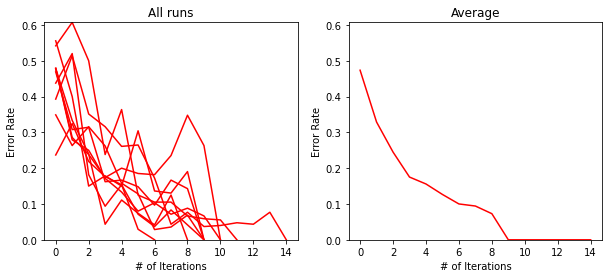

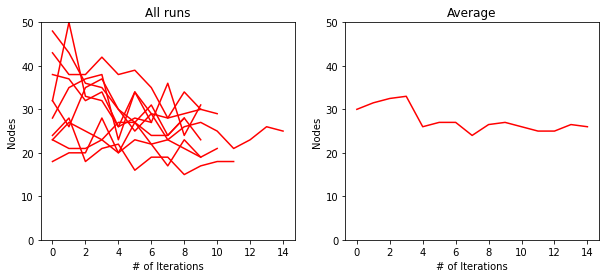

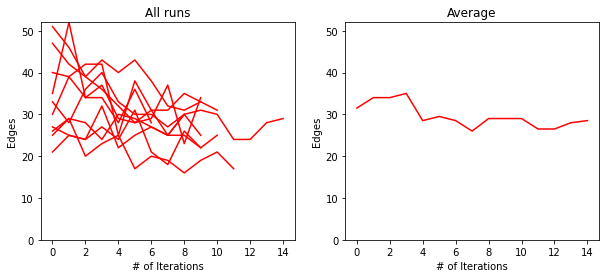

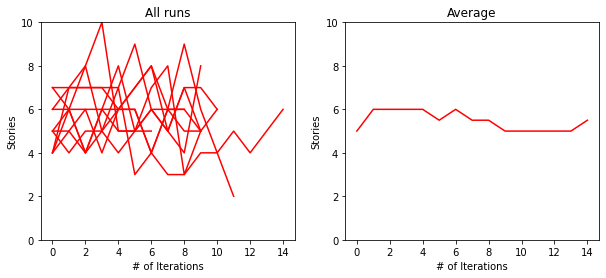

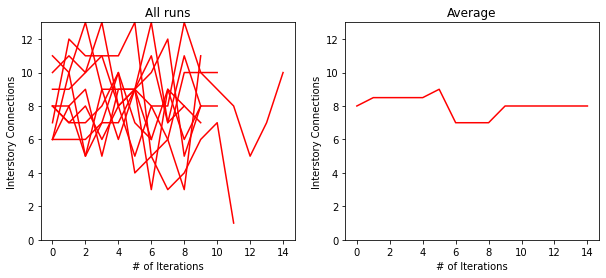

In [23]:
plot_all(all_iterations, all_percents, all_complexities)

### Fox and Breitbart only

In [24]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
for i in range(total_samples):
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_nodes = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_nodes > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[124], previous_actions=previous_actions, verbose=False, random_state=random_state, use_new_LP=True)
        filter_nodes = graph_df[graph_df['url'].str.contains('foxnews') | graph_df['url'].str.contains('breitbart')]
        percent_filter_nodes = len(filter_nodes.index) / len(graph_df.index)
        remove_node_list = [str(node) for node in filter_nodes.id.tolist()]
        remove_node = {"action": "remove-node", "content": remove_node_list}
        previous_actions.append(remove_node)
        percent_list.append(percent_filter_nodes)
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_nodes, remove_node)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    actions = []
    for action in previous_actions:
        actions += action['content']
    all_iterations.append(inner_iter_count)
    all_percents.append(percent_list)
    all_counts.append(len(actions))
    all_complexities.append(complexity)

Sample #0
Step: 1 0.18421052631578946 {'action': 'remove-node', 'content': ['136', '169', '172', '202', '205', '231', '239']}
Complexity: [38, 40, 7, 7, 0, 9]
Step: 2 0.28125 {'action': 'remove-node', 'content': ['179', '192', '209', '232', '233', '252', '331', '427', '451']}
Complexity: [32, 33, 5, 5, 0, 6]
Step: 3 0.09375 {'action': 'remove-node', 'content': ['322', '426', '449']}
Complexity: [32, 35, 6, 5, 1, 9]
Step: 4 0.10810810810810811 {'action': 'remove-node', 'content': ['371', '405', '413', '448']}
Complexity: [37, 39, 7, 6, 1, 9]
Step: 5 0.03571428571428571 {'action': 'remove-node', 'content': ['301']}
Complexity: [28, 28, 4, 3, 1, 4]
Step: 6 0.0 {'action': 'remove-node', 'content': []}
Complexity: [26, 28, 6, 5, 1, 8]
Sample #1
Step: 1 0.4444444444444444 {'action': 'remove-node', 'content': ['157', '201', '206', '218', '252', '322', '329', '414']}
Complexity: [18, 21, 4, 4, 0, 7]
Step: 2 0.47058823529411764 {'action': 'remove-node', 'content': ['128', '220', '230', '231', '

Step: 14 0.09523809523809523 {'action': 'remove-node', 'content': ['261', '427']}
Complexity: [21, 24, 7, 2, 5, 10]
Step: 15 0.0 {'action': 'remove-node', 'content': []}
Complexity: [20, 23, 7, 5, 2, 10]
Sample #6
Step: 1 0.375 {'action': 'remove-node', 'content': ['137', '169', '199', '201', '222', '225', '226', '227', '231', '252', '267', '342']}
Complexity: [32, 35, 5, 4, 1, 8]
Step: 2 0.42857142857142855 {'action': 'remove-node', 'content': ['212', '233', '244', '259', '268', '311', '312', '322', '323', '325', '331', '341', '345', '386', '405', '417', '430', '448']}
Complexity: [42, 43, 6, 5, 1, 7]
Step: 3 0.23529411764705882 {'action': 'remove-node', 'content': ['251', '316', '319', '393', '411', '414', '481', '484']}
Complexity: [34, 35, 5, 4, 1, 6]
Step: 4 0.12903225806451613 {'action': 'remove-node', 'content': ['136', '159', '257', '426']}
Complexity: [31, 33, 6, 5, 1, 8]
Step: 5 0.13333333333333333 {'action': 'remove-node', 'content': ['218', '262', '332', '427']}
Complexity:

In [25]:
results_delete_right = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_delete_fox_bb_full.json', 'w') as fp:
    json.dump(results_delete_right, fp)

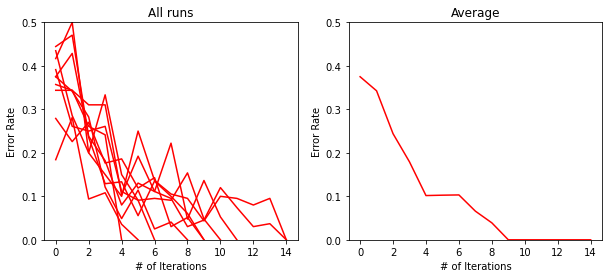

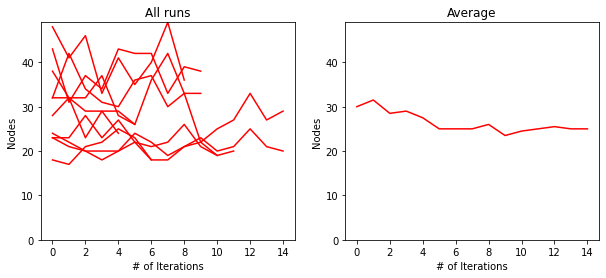

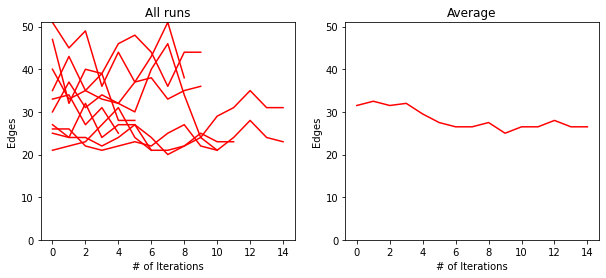

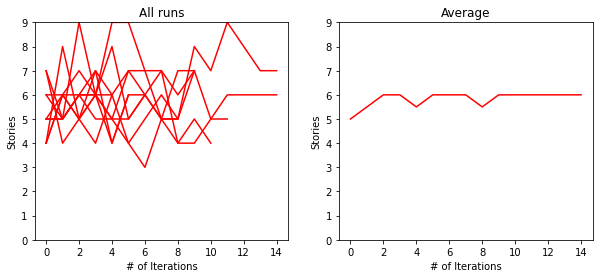

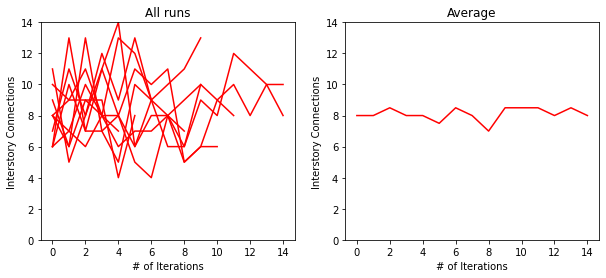

In [26]:
plot_all(all_iterations, all_percents, all_complexities)

### Removing Miami + Florida references
There's 39 after the protests start.

In [27]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
i = 0
total_samples = base_total_samples
while i < total_samples:
    drop = False
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_nodes = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_nodes > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[124], previous_actions=previous_actions, 
                                               verbose=False, random_state=random_state, force_cluster=False, use_new_LP=True)
        filter_nodes = graph_df[graph_df.title.str.contains('miami', case=False) | 
                                   graph_df.title.str.contains('florida', case=False)]
        percent_filter_nodes = len(filter_nodes.index) / len(graph_df.index)
        remove_node_list = [str(node) for node in filter_nodes.id.tolist()]
        remove_node = {"action": "remove-node", "content": remove_node_list}
        previous_actions.append(remove_node)
        percent_list.append(percent_filter_nodes)
        if percent_filter_nodes == 0 and inner_iter_count == 0: # first iteration has no miami/florida nodes. 
            drop = True
            total_samples += 1
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_nodes, remove_node)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    actions = []
    i += 1
    for action in previous_actions:
        actions += action['content']
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0
Step: 1 0.05263157894736842 {'action': 'remove-node', 'content': ['169', '250']}
Complexity: [38, 40, 7, 7, 0, 9]
Step: 2 0.058823529411764705 {'action': 'remove-node', 'content': ['175', '233']}
Complexity: [34, 36, 4, 4, 0, 6]
Step: 3 0.03225806451612903 {'action': 'remove-node', 'content': ['223']}
Complexity: [31, 33, 6, 4, 2, 8]
Step: 4 0.023809523809523808 {'action': 'remove-node', 'content': ['433']}
Complexity: [42, 46, 9, 6, 3, 13]
Step: 5 0.0 {'action': 'remove-node', 'content': []}
Complexity: [38, 41, 7, 7, 0, 10]
Sample #1
Step: 1 0.16666666666666666 {'action': 'remove-node', 'content': ['402', '414', '429']}
Complexity: [18, 21, 4, 4, 0, 7]
Step: 2 0.047619047619047616 {'action': 'remove-node', 'content': ['481']}
Complexity: [21, 23, 6, 2, 4, 8]
Step: 3 0.07692307692307693 {'action': 'remove-node', 'content': ['181', '454']}
Complexity: [26, 30, 8, 5, 3, 12]
Step: 4 0.0 {'action': 'remove-node', 'content': []}
Complexity: [21, 24, 4, 4, 0, 7]
Sample #2
Step: 1 

In [28]:
results_delete_florida = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_delete_florida_full.json', 'w') as fp:
    json.dump(results_delete_florida, fp)

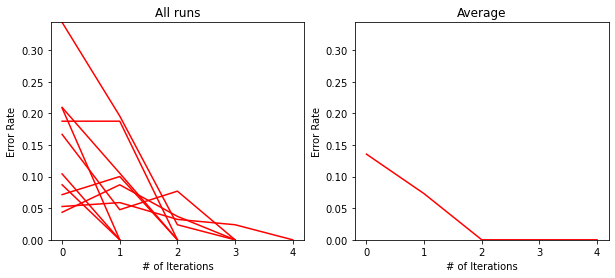

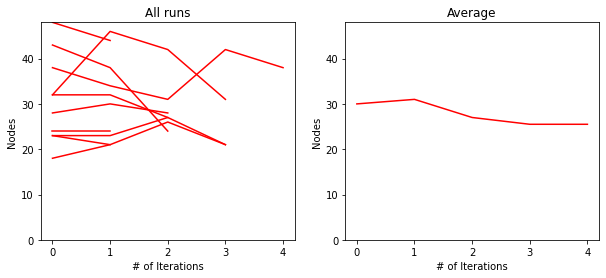

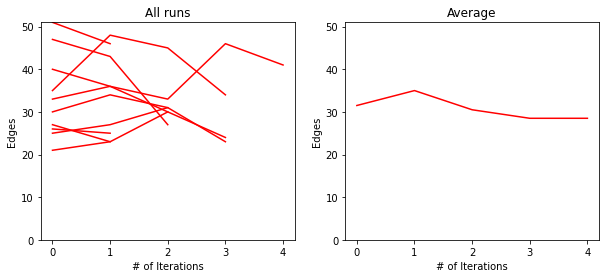

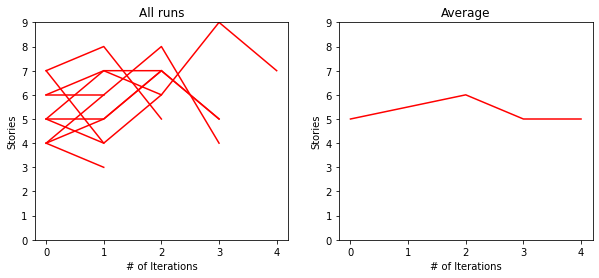

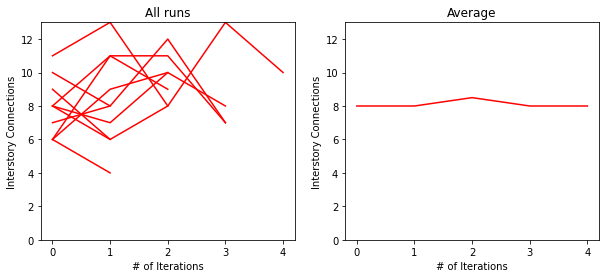

In [29]:
plot_all(all_iterations, all_percents, all_complexities)

## Remove Edges
### Remove Inconsistent Edges
Goal: Remove right-biased news articles from the map. We use the same starting point from before.

In [30]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
for i in range(total_samples):
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_edges = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_edges > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[124], previous_actions=previous_actions, verbose=False, random_state=random_state, use_new_LP=True)
        edges = list(G.edges())
        filter_edges = []
        for node_i, node_j in edges:
            bias_i = graph_df.loc[graph_df['id'] == int(node_i)].iloc[0]['bias']
            bias_j = graph_df.loc[graph_df['id'] == int(node_j)].iloc[0]['bias']
            if (bias_i == 'Right' and bias_j == 'Left') or (bias_i == 'Left' and bias_j == 'Right'):
                filter_edges.append((node_i, node_j))
        remove_edge_list = [node_i + "-" + node_j for node_i, node_j in filter_edges]
        percent_filter_edges = len(filter_edges) / len(edges)
        
        remove_edge = {"action": "remove-edge", "content": remove_edge_list}
        previous_actions.append(remove_edge)
        percent_list.append(percent_filter_edges)
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_edges, remove_edge)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    actions = []
    for action in previous_actions:
        actions += action['content']
    all_iterations.append(inner_iter_count)
    all_percents.append(percent_list)
    all_counts.append(len(actions))
    all_complexities.append(complexity)

Sample #0
Step: 1 0.1 {'action': 'remove-edge', 'content': ['172-196', '196-202', '202-208', '208-239']}
Complexity: [38, 40, 7, 7, 0, 9]
Step: 2 0.21621621621621623 {'action': 'remove-edge', 'content': ['169-208', '208-240', '337-339', '339-373', '381-410', '410-435', '435-441', '441-483']}
Complexity: [35, 37, 6, 4, 2, 8]
Step: 3 0.1794871794871795 {'action': 'remove-edge', 'content': ['231-286', '252-276', '337-345', '345-373', '382-410', '410-483', '427-492']}
Complexity: [38, 39, 5, 4, 1, 6]
Step: 4 0.13513513513513514 {'action': 'remove-edge', 'content': ['231-238', '331-337', '379-410', '412-428', '428-461']}
Complexity: [34, 37, 6, 4, 2, 9]
Step: 5 0.022727272727272728 {'action': 'remove-edge', 'content': ['208-231']}
Complexity: [41, 44, 7, 5, 2, 10]
Step: 6 0.027777777777777776 {'action': 'remove-edge', 'content': ['348-364']}
Complexity: [35, 36, 5, 4, 1, 6]
Step: 7 0.0 {'action': 'remove-edge', 'content': []}
Complexity: [29, 30, 4, 3, 1, 5]
Sample #1
Step: 1 0.142857142857

Step: 3 0.030303030303030304 {'action': 'remove-edge', 'content': ['252-377']}
Complexity: [29, 33, 7, 5, 2, 11]
Step: 4 0.05555555555555555 {'action': 'remove-edge', 'content': ['252-373', '267-304']}
Complexity: [31, 36, 8, 5, 3, 13]
Step: 5 0.05263157894736842 {'action': 'remove-edge', 'content': ['375-380', '383-392']}
Complexity: [34, 38, 8, 5, 3, 12]
Step: 6 0.02564102564102564 {'action': 'remove-edge', 'content': ['375-377']}
Complexity: [35, 39, 8, 5, 3, 12]
Step: 7 0.0 {'action': 'remove-edge', 'content': []}
Complexity: [33, 37, 7, 5, 2, 11]
Sample #7
Step: 1 0.15151515151515152 {'action': 'remove-edge', 'content': ['252-254', '267-273', '242-254', '273-330', '435-441']}
Complexity: [32, 33, 5, 5, 0, 6]
Step: 2 0.02564102564102564 {'action': 'remove-edge', 'content': ['254-263']}
Complexity: [39, 39, 5, 5, 0, 5]
Step: 3 0.05405405405405406 {'action': 'remove-edge', 'content': ['252-273', '225-304']}
Complexity: [36, 37, 7, 7, 0, 8]
Step: 4 0.1 {'action': 'remove-edge', 'conte

In [31]:
results_delete_edges = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_delete_edges_full.json', 'w') as fp:
    json.dump(results_delete_edges, fp)

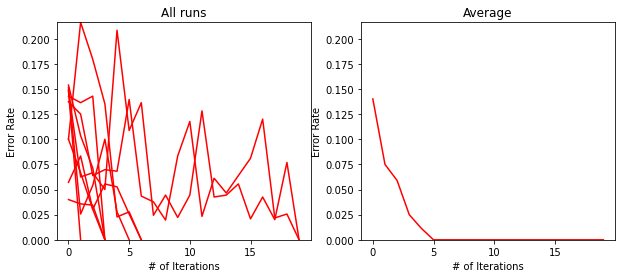

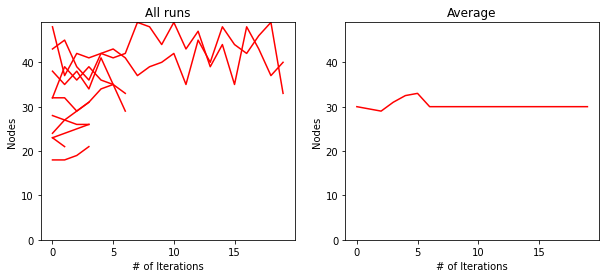

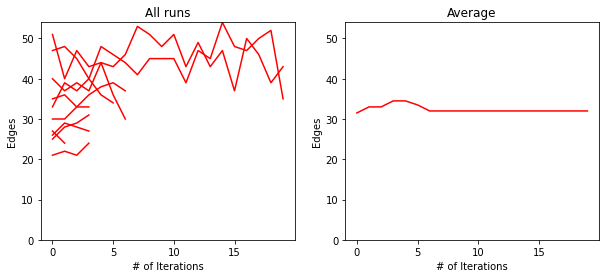

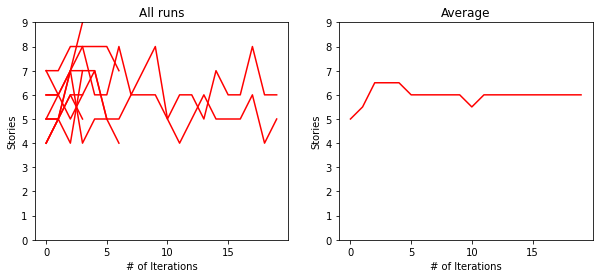

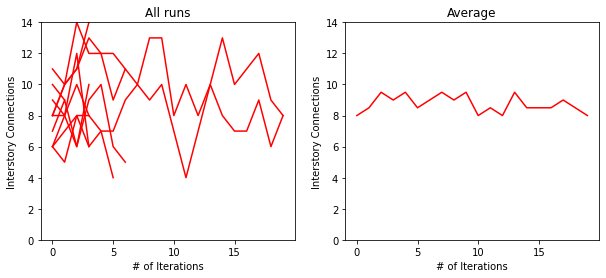

In [32]:
plot_all(all_iterations, all_percents, all_complexities)

## Add Edges + Remove Edges
### Make Storylines Consistent (Starting from "Center" Storyline)

In [33]:
from collections import Counter
def most_common(lst):
    # Exclude local and center.
    lst[:] = [x for x in lst if x != 'Center' and x != 'Local']
    if len(lst) == 0:
        return None
    data = Counter(lst)
    return max(lst, key=data.get)

In [34]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples

for i in range(total_samples):
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_nodes = 1.0
    percent_list_nodes = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_nodes > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[124], previous_actions=previous_actions, verbose=False, random_state=random_state, use_new_LP=True)
        nodes = list(G.nodes())
        remove_node_list = []
        add_edges = []
        #print("Storylines: " + str(storylines))
        for story in storylines:
            #print("Current story: " + str(story))
            story_biases = [graph_df.loc[graph_df['id'] == int(story_node)].iloc[0]['bias'] for story_node in story]
            story_bias = most_common(story_biases)
            opposite_bias = None
            if story_bias == 'Left':
                opposite_bias = 'Right'
            else:
                opposite_bias = 'Left'
            skip_count = 0
            mark = None
            if opposite_bias is not None:
                for node in story:
                    bias = graph_df.loc[graph_df['id'] == int(node)].iloc[0]['bias']
                    if mark is not None and skip_count > 0 and bias != opposite_bias:
                        add_edge = {"action": "add-edge", "content": str(mark) + "-" + str(node)} # String of edge id
                        add_edges.append(str(mark) + "-" + str(node))
                        previous_actions.append(add_edge)
                        mark = node
                        skip_count = 0
                    if bias != opposite_bias:
                        mark = node
                    else:
                        remove_node_list.append(node)
                        skip_count += 1            
        remove_node = {"action": "remove-node", "content": remove_node_list}
        for node in remove_node_list:
            previous_actions[:] = [action for action in previous_actions if not (action['action'] == 'add-edge' and str(node) in action['content'].split("-"))]
        previous_actions.append(remove_node)                
        percent_filter_nodes = len(remove_node_list) / len(nodes)              
        percent_list_nodes.append(percent_filter_nodes)
        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_nodes, remove_node, "add-edge: " + str(add_edges))
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    actions = []
    for action in previous_actions:
        if type(action['content']) == list:
            actions += action['content']
        else:
            actions.append(action['content'])
    all_iterations.append(inner_iter_count)
    all_percents.append(percent_list_nodes)
    all_counts.append(len(actions))
    all_complexities.append(complexity)

Sample #0
Step: 1 0.15789473684210525 {'action': 'remove-node', 'content': ['169', '231', '196', '208', '472', '382']} add-edge: ['124-198', '198-235', '172-202', '202-239']
Complexity: [38, 40, 7, 7, 0, 9]
Step: 2 0.08333333333333333 {'action': 'remove-node', 'content': ['215', '276', '373']} add-edge: ['205-233', '252-331', '372-375']
Complexity: [36, 36, 9, 6, 3, 9]
Step: 3 0.11764705882352941 {'action': 'remove-node', 'content': ['337', '356', '476', '238']} add-edge: ['235-432', '326-397']
Complexity: [34, 34, 8, 5, 3, 8]
Step: 4 0.08823529411764706 {'action': 'remove-node', 'content': ['474', '435', '439']} add-edge: ['432-440']
Complexity: [34, 33, 9, 7, 2, 8]
Step: 5 0.05555555555555555 {'action': 'remove-node', 'content': ['352', '381']} add-edge: ['343-426']
Complexity: [36, 34, 9, 6, 3, 7]
Step: 6 0.029411764705882353 {'action': 'remove-node', 'content': ['178']} add-edge: ['184-235']
Complexity: [34, 34, 9, 4, 5, 9]
Step: 7 0.08108108108108109 {'action': 'remove-node', 'con

Step: 2 0.05555555555555555 {'action': 'remove-node', 'content': ['355', '238']} add-edge: ['345-437']
Complexity: [36, 37, 5, 5, 0, 6]
Step: 3 0.11764705882352941 {'action': 'remove-node', 'content': ['201', '427', '254', '473']} add-edge: ['245-320', '404-429', '160-263']
Complexity: [34, 38, 7, 5, 2, 11]
Step: 4 0.05263157894736842 {'action': 'remove-node', 'content': ['252', '290']} add-edge: ['124-335', '282-328']
Complexity: [38, 40, 7, 5, 2, 9]
Step: 5 0.07317073170731707 {'action': 'remove-node', 'content': ['429', '301', '308']} add-edge: ['414-450']
Complexity: [41, 40, 16, 7, 9, 15]
Step: 6 0.11904761904761904 {'action': 'remove-node', 'content': ['203', '183', '210', '234', '357']} add-edge: ['160-243', '199-204', '204-224', '224-342', '316-411']
Complexity: [42, 43, 9, 7, 2, 10]
Step: 7 0.043478260869565216 {'action': 'remove-node', 'content': ['278', '393']} add-edge: ['268-315']
Complexity: [46, 48, 12, 8, 4, 14]
Step: 8 0.0 {'action': 'remove-node', 'content': []} add-e

In [35]:
results_consistent_story = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_consistent_story_full.json', 'w') as fp:
    json.dump(results_consistent_story, fp)

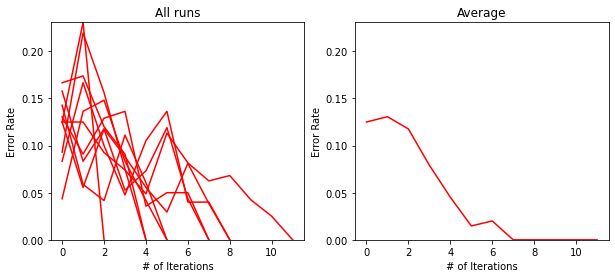

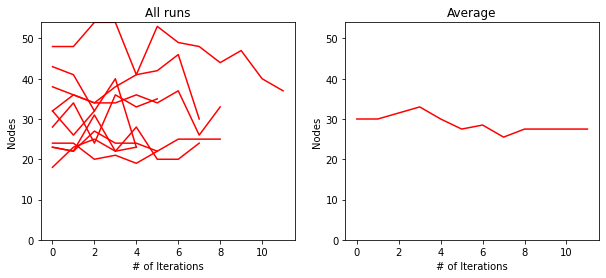

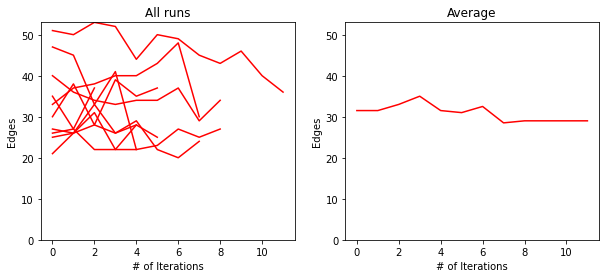

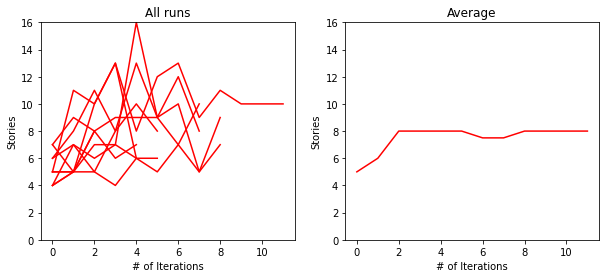

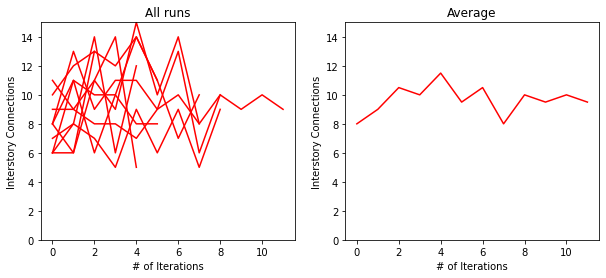

In [36]:
plot_all(all_iterations, all_percents, all_complexities)

## "Clustering"
2 clusters only: High-bias Breitbart vs Center-unbiased storylines.
Metric: internal storyline consistency (avoid connections between high-bias and low-bias articles)

### Semi-supervised umap with constraints

In [37]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
i = 0
total_samples = base_total_samples
while i < total_samples:
    print("===================================")
    print("Sample #" + str(i) + " (Valid Sample #" + str(len(all_complexities)) + ")")
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consistent throughout the same iteration.
    drop = False
    while percent_filter > 0:
        G, graph_df, storylines = generate_map(query, dataset, k_input=8, start_nodes=[124], previous_actions=previous_actions, 
                                               verbose=False, random_state=random_state, force_cluster=True, use_new_LP=True)
        nodes = list(G.edges())
        
        breitbart_nodes = graph_df[graph_df.url.str.contains('breitbart')] # Cluster 1
        center_nodes = graph_df[graph_df.bias == 'Center'] # Cluster 2
        breitbart_cluster_full = [str(node) for node in breitbart_nodes['id'].tolist()]
        center_cluster_full = [str(node) for node in center_nodes['id'].tolist()]
        
        previous_breitbart = [node for node_list in previous_actions for node in node_list["content"][0] if node_list["content"][1] == 1]
        previous_center = [node for node_list in previous_actions for node in node_list["content"][0] if node_list["content"][1] == 2]

        print("Previous actions:")
        print(previous_breitbart)
        print(previous_center)
        
        breitbart_cluster_int = sorted([int(node) for node in list(set(breitbart_cluster_full).difference(previous_breitbart))])
        center_cluster_int = sorted([int(node) for node in list(set(center_cluster_full).difference(previous_center))])
        
        breitbart_cluster = [str(node) for node in breitbart_cluster_int]
        center_cluster = [str(node) for node in center_cluster_int]
        
        breitbart_action = {"action": "add-cluster-list", "content": [breitbart_cluster[:min(3, len(breitbart_cluster))], 1]}
        center_action = {"action": "add-cluster-list", "content": [center_cluster[:min(3, len(center_cluster))], 2]}
        
        previous_actions.append(breitbart_action)
        previous_actions.append(center_action)
        
        non_isolated_nodes = set()
        breitbart_n = len(breitbart_cluster_full)
        center_n = len(center_cluster_full)

        count_same_story = 0
        count_direct_connection = 0
        count_same_parent = 0
        count_same_children = 0
        for combination in itertools.combinations(breitbart_cluster_full,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1
                
        for combination in itertools.combinations(center_cluster_full,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            try:
                sp_1 = nx.shortest_path_length(G, combination[0], combination[1])
            except nx.NetworkXNoPath:
                sp_1 = 0
            try:
                sp_2 = nx.shortest_path_length(G, combination[1], combination[0])
            except nx.NetworkXNoPath:
                sp_2 = 0
            has_path = (sp_1 == 2) or (sp_2 == 2) # Separation of 2. 
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1

                
        print("Total cluster 1: " + str(breitbart_n))
        print("Total cluster 2: " + str(center_n))
        print("Same story " + str(count_same_story), 
              "Direct connection " + str(count_direct_connection), 
              "Same parent " + str(count_same_parent),
              "Same children " + str(count_same_children))
        if breitbart_n + center_n == 0:
            percent_filter = 0.0
        else:        
            percent_filter = 1 - len(non_isolated_nodes) / (breitbart_n + center_n)
        percent_list.append(percent_filter)
        
        if percent_filter == 0 and inner_iter_count == 0: 
            # if the map was perfect from the start, we will need more samples and we should drop this one.
            drop = True
            total_samples += 1
        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter, breitbart_action, center_action)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
        
        if len(breitbart_cluster) == 0 and len(center_cluster) == 0:
            print("Nothing to add - Early stopping.")
            break
        
    i += 1
    actions = []
    for action in previous_actions:
        if action['action'] == 'add-cluster-list':
            actions += action['content'][0] 
        elif type(action['content']) == list:
            actions += action['content']
        else:
            actions.append(action['content'])
            
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0 (Valid Sample #0)
Previous actions:
[]
[]
Total cluster 1: 3
Total cluster 2: 14
Same story 20 Direct connection 0 Same parent 1 Same children 0
Step: 1 0.23529411764705888 {'action': 'add-cluster-list', 'content': [['172', '205', '239'], 1]} {'action': 'add-cluster-list', 'content': [['124', '198', '235'], 2]}
Complexity: [38, 40, 7, 7, 0, 9]
Previous actions:
['172', '205', '239']
['124', '198', '235']
Total cluster 1: 8
Total cluster 2: 12
Same story 9 Direct connection 4 Same parent 1 Same children 2
Step: 2 0.15000000000000002 {'action': 'add-cluster-list', 'content': [['226', '341', '386'], 1]} {'action': 'add-cluster-list', 'content': [['258', '344', '389'], 2]}
Complexity: [51, 57, 16, 10, 6, 22]
Previous actions:
['172', '205', '239', '226', '341', '386']
['124', '198', '235', '258', '344', '389']
Total cluster 1: 10
Total cluster 2: 15
Same story 24 Direct connection 4 Same parent 2 Same children 3
Step: 3 0.12 {'action': 'add-cluster-list', 'content': [['179', '194

Previous actions:
['191', '201', '232', '157', '386', '391', '159', '172', '194', '179', '192', '301', '145', '153', '316']
['124', '187', '297', '149', '295', '309', '188', '204', '249', '334', '376', '438', '185', '408']
Total cluster 1: 20
Total cluster 2: 19
Same story 37 Direct connection 11 Same parent 2 Same children 9
Step: 6 0.07692307692307687 {'action': 'add-cluster-list', 'content': [['170', '371', '426'], 1]} {'action': 'add-cluster-list', 'content': [['146', '372', '389'], 2]}
Complexity: [58, 65, 17, 12, 5, 24]
Previous actions:
['191', '201', '232', '157', '386', '391', '159', '172', '194', '179', '192', '301', '145', '153', '316', '170', '371', '426']
['124', '187', '297', '149', '295', '309', '188', '204', '249', '334', '376', '438', '185', '408', '146', '372', '389']
Total cluster 1: 20
Total cluster 2: 22
Same story 111 Direct connection 6 Same parent 2 Same children 7
Step: 7 0.023809523809523836 {'action': 'add-cluster-list', 'content': [['230', '484'], 1]} {'acti

Previous actions:
['159', '225', '230', '157', '194', '201']
['124', '235', '297', '148', '204', '318']
Total cluster 1: 9
Total cluster 2: 10
Same story 26 Direct connection 3 Same parent 1 Same children 3
Step: 3 0.1578947368421053 {'action': 'add-cluster-list', 'content': [['140', '430', '453'], 1]} {'action': 'add-cluster-list', 'content': [['171', '369', '454'], 2]}
Complexity: [53, 58, 15, 9, 6, 20]
Previous actions:
['159', '225', '230', '157', '194', '201', '140', '430', '453']
['124', '235', '297', '148', '204', '318', '171', '369', '454']
Total cluster 1: 20
Total cluster 2: 13
Same story 35 Direct connection 5 Same parent 0 Same children 7
Step: 4 0.12121212121212122 {'action': 'add-cluster-list', 'content': [['192', '226', '301'], 1]} {'action': 'add-cluster-list', 'content': [['344', '378', '407'], 2]}
Complexity: [59, 62, 12, 9, 3, 15]
Previous actions:
['159', '225', '230', '157', '194', '201', '140', '430', '453', '192', '226', '301']
['124', '235', '297', '148', '204',

Previous actions:
['201', '225', '227', '140', '157', '159', '158', '161', '191', '301', '371', '392']
['124', '184', '335', '130', '146', '148', '149', '204', '249', '378', '465']
Total cluster 1: 20
Total cluster 2: 16
Same story 33 Direct connection 23 Same parent 12 Same children 9
Step: 5 0.19444444444444442 {'action': 'add-cluster-list', 'content': [['145', '170', '222'], 1]} {'action': 'add-cluster-list', 'content': [['171', '188', '198'], 2]}
Complexity: [85, 105, 34, 15, 19, 54]
Previous actions:
['201', '225', '227', '140', '157', '159', '158', '161', '191', '301', '371', '392', '145', '170', '222']
['124', '184', '335', '130', '146', '148', '149', '204', '249', '378', '465', '171', '188', '198']
Total cluster 1: 21
Total cluster 2: 24
Same story 65 Direct connection 20 Same parent 11 Same children 11
Step: 6 0.0444444444444444 {'action': 'add-cluster-list', 'content': [['230', '241', '294'], 1]} {'action': 'add-cluster-list', 'content': [['235', '270', '297'], 2]}
Complexity

Previous actions:
['267', '316', '386', '206', '227', '365']
['124', '285', '235', '243', '249']
Total cluster 1: 7
Total cluster 2: 11
Same story 26 Direct connection 3 Same parent 1 Same children 1
Step: 3 0.11111111111111116 {'action': 'add-cluster-list', 'content': [['393'], 1]} {'action': 'add-cluster-list', 'content': [['171', '270', '376'], 2]}
Complexity: [32, 32, 9, 6, 3, 9]
Previous actions:
['267', '316', '386', '206', '227', '365', '393']
['124', '285', '235', '243', '249', '171', '270', '376']
Total cluster 1: 14
Total cluster 2: 17
Same story 16 Direct connection 8 Same parent 4 Same children 12
Step: 4 0.09677419354838712 {'action': 'add-cluster-list', 'content': [['170', '225', '230'], 1]} {'action': 'add-cluster-list', 'content': [['148', '184', '188'], 2]}
Complexity: [47, 52, 17, 13, 4, 22]
Previous actions:
['267', '316', '386', '206', '227', '365', '393', '170', '225', '230']
['124', '285', '235', '243', '249', '171', '270', '376', '148', '184', '188']
Total cluste

In [38]:
results_clustering = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_clustering_bb_center_full.json', 'w') as fp:
    json.dump(results_clustering, fp)

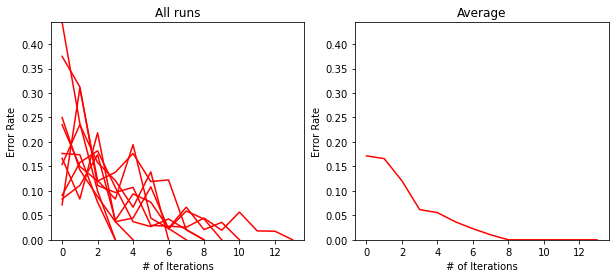

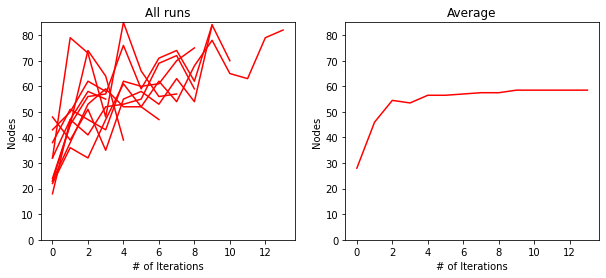

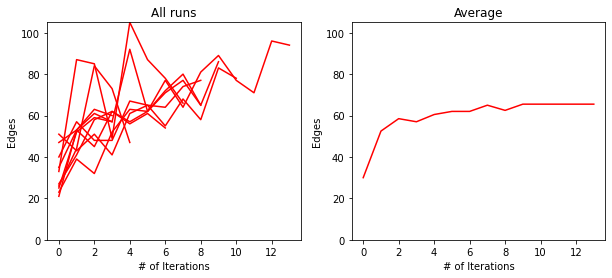

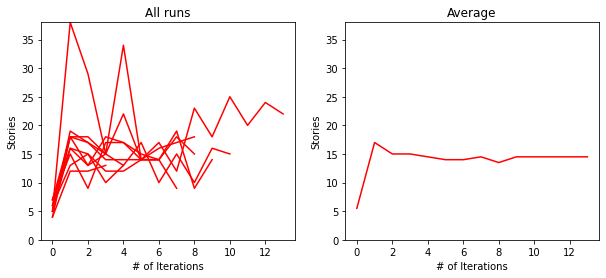

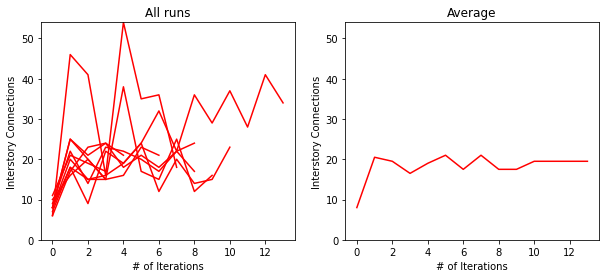

In [39]:
plot_all(all_iterations, all_percents, all_complexities)

### Test with Florida/Miami news vs general US news

In [40]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
i = 0
total_samples = base_total_samples
while i < total_samples:
    print("===================================")
    print("Sample #" + str(i) + " (Valid Sample #" + str(len(all_complexities)) + ")")
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    drop = False
    
    while percent_filter > 0:
        G, graph_df, storylines = generate_map(query, dataset, k_input=8, start_nodes=[124], previous_actions=previous_actions, 
                                               verbose=False, random_state=random_state, force_cluster=True, use_new_LP=True)
        nodes = list(G.edges())
        
        breitbart_nodes = graph_df[graph_df.title.str.contains('miami', case=False) | 
                                   graph_df.title.str.contains('florida', case=False)] # Cluster 1
        center_nodes = graph_df[(graph_df.title.str.contains(r'(?:\s|\b)[Uu](?:\.)?[sS](?:\.)?[Aa]?(?:\.)?(?:\s|\b)', regex=True) |
                                 graph_df.title.str.contains('united states', case=False)) & 
                                 ~(graph_df.title.str.contains('miami', case=False) 
                                   | graph_df.title.str.contains('florida', case=False))] # Cluster 2
        breitbart_cluster = [str(node) for node in breitbart_nodes['id'].tolist()]
        center_cluster = [str(node) for node in center_nodes['id'].tolist()]
        
        breitbart_action = {"action": "add-cluster-list", "content": [breitbart_cluster[:min(3, len(breitbart_cluster))], 1]}
        center_action = {"action": "add-cluster-list", "content": [center_cluster[:min(3, len(center_cluster))], 2]}

        breitbart_cluster_full = [str(node) for node in breitbart_nodes['id'].tolist()]
        center_cluster_full = [str(node) for node in center_nodes['id'].tolist()]
        
        previous_breitbart = [node for node_list in previous_actions for node in node_list["content"][0] if node_list["content"][1] == 1]
        previous_center = [node for node_list in previous_actions for node in node_list["content"][0] if node_list["content"][1] == 2]

        print("Previous actions:")
        print(previous_breitbart)
        print(previous_center)
        
        breitbart_cluster_int = sorted([int(node) for node in list(set(breitbart_cluster_full).difference(previous_breitbart))])
        center_cluster_int = sorted([int(node) for node in list(set(center_cluster_full).difference(previous_center))])
        
        breitbart_cluster = [str(node) for node in breitbart_cluster_int]
        center_cluster = [str(node) for node in center_cluster_int]
        
        breitbart_action = {"action": "add-cluster-list", "content": [breitbart_cluster, 1]}
        center_action = {"action": "add-cluster-list", "content": [center_cluster, 2]}
        
        previous_actions.append(breitbart_action)
        previous_actions.append(center_action)
        
        non_isolated_nodes = set()
        breitbart_n = len(breitbart_cluster_full)
        center_n = len(center_cluster_full)

        count_same_story = 0
        count_direct_connection = 0
        count_same_parent = 0
        count_same_children = 0
        count_has_path = 0
        for combination in itertools.combinations(breitbart_cluster_full,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1
                
        for combination in itertools.combinations(center_cluster_full,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1

        print("Total cluster 1: " + str(breitbart_n))
        print("Total cluster 2: " + str(center_n))
        print("Same story " + str(count_same_story), 
              "Direct connection " + str(count_direct_connection), 
              "Same parent " + str(count_same_parent),
              "Same children " + str(count_same_children))
        
        if breitbart_n + center_n == 0:
            percent_filter = 0.0
        else:
            percent_filter = 1 - len(non_isolated_nodes) / (breitbart_n + center_n)
        
        if percent_filter == 0 and inner_iter_count == 0: 
            # if the map was perfect from the start, we will need more samples and we should drop this one.
            drop = True
            total_samples += 1
            
        percent_list.append(percent_filter)

        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter, breitbart_action, center_action)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
        
        if len(breitbart_cluster) == 0 and len(center_cluster) == 0:
            print("Nothing to add - Early stopping.")
            break
    i += 1
    actions = []
    for action in previous_actions:
        if action['action'] == 'add-cluster-list':
            actions += action['content'][0] 
        elif type(action['content']) == list:
            actions += action['content']
        else:
            actions.append(action['content'])
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0 (Valid Sample #0)
Previous actions:
[]
[]
Total cluster 1: 2
Total cluster 2: 8
Same story 6 Direct connection 1 Same parent 0 Same children 0
Step: 1 0.4 {'action': 'add-cluster-list', 'content': [['169', '250'], 1]} {'action': 'add-cluster-list', 'content': [['198', '270', '289', '339', '376', '382', '432', '473'], 2]}
Complexity: [38, 40, 7, 7, 0, 9]
Previous actions:
['169', '250']
['198', '270', '289', '339', '376', '382', '432', '473']
Total cluster 1: 4
Total cluster 2: 16
Same story 18 Direct connection 3 Same parent 1 Same children 5
Step: 2 0.19999999999999996 {'action': 'add-cluster-list', 'content': [['223', '256'], 1]} {'action': 'add-cluster-list', 'content': [['203', '227', '255', '353', '363', '377', '379', '441'], 2]}
Complexity: [55, 63, 20, 13, 7, 28]
Previous actions:
['169', '250', '223', '256']
['198', '270', '289', '339', '376', '382', '432', '473', '203', '227', '255', '353', '363', '377', '379', '441']
Total cluster 1: 4
Total cluster 2: 22
Same story

Previous actions:
['247', '273', '300', '414', '429', '237', '402', '170', '181', '186', '188', '193', '197', '217', '223', '245', '304', '305', '313', '233', '433', '292', '454']
['303', '162', '167', '173', '190', '224', '272', '296', '297', '338', '381', '441', '133', '149', '160', '227', '462', '132', '143', '148', '204', '210', '344', '355', '371', '376', '377', '383', '419', '465', '382']
Total cluster 1: 23
Total cluster 2: 31
Same story 76 Direct connection 16 Same parent 2 Same children 37
Step: 6 0.0 {'action': 'add-cluster-list', 'content': [[], 1]} {'action': 'add-cluster-list', 'content': [[], 2]}
Complexity: [66, 70, 21, 15, 6, 25]
Nothing to add - Early stopping.
Sample #5 (Valid Sample #3)
Previous actions:
[]
[]
Total cluster 1: 2
Total cluster 2: 3
Same story 0 Direct connection 0 Same parent 0 Same children 0
Step: 1 1.0 {'action': 'add-cluster-list', 'content': [['273', '460'], 1]} {'action': 'add-cluster-list', 'content': [['162', '297', '339'], 2]}
Complexity: [23

Previous actions:
['414', '429', '193', '217', '181', '182', '188', '197', '273', '313', '237', '300', '390', '395']
['296', '297', '462', '148', '149', '339', '133', '227', '204', '255', '369', '432', '473']
Total cluster 1: 18
Total cluster 2: 20
Same story 75 Direct connection 6 Same parent 0 Same children 11
Step: 5 0.10526315789473684 {'action': 'add-cluster-list', 'content': [['233', '256', '396', '454'], 1]} {'action': 'add-cluster-list', 'content': [['132', '173', '199', '268', '277', '331', '344'], 2]}
Complexity: [59, 60, 19, 9, 10, 20]
Previous actions:
['414', '429', '193', '217', '181', '182', '188', '197', '273', '313', '237', '300', '390', '395', '233', '256', '396', '454']
['296', '297', '462', '148', '149', '339', '133', '227', '204', '255', '369', '432', '473', '132', '173', '199', '268', '277', '331', '344']
Total cluster 1: 18
Total cluster 2: 28
Same story 90 Direct connection 13 Same parent 1 Same children 13
Step: 6 0.0 {'action': 'add-cluster-list', 'content': [

Previous actions:
['256', '169', '170', '197', '223', '395']
['198', '203', '270', '497', '132', '133', '137', '143', '144', '148', '160', '162', '167', '173', '178', '190', '227', '289', '334', '369', '371', '376', '377', '380', '419', '462', '465']
Total cluster 1: 9
Total cluster 2: 28
Same story 17 Direct connection 24 Same parent 6 Same children 173
Step: 3 0.0 {'action': 'add-cluster-list', 'content': [['182', '193', '217'], 1]} {'action': 'add-cluster-list', 'content': [['149'], 2]}
Complexity: [75, 88, 23, 15, 8, 36]
Sample #12 (Valid Sample #9)
Previous actions:
[]
[]
Total cluster 1: 4
Total cluster 2: 4
Same story 3 Direct connection 1 Same parent 1 Same children 0
Step: 1 0.0 {'action': 'add-cluster-list', 'content': [['175', '223', '414', '433'], 1]} {'action': 'add-cluster-list', 'content': [['270', '376', '379', '465'], 2]}
Complexity: [21, 24, 5, 3, 2, 8]
Sample #13 (Valid Sample #9)
Previous actions:
[]
[]
Total cluster 1: 5
Total cluster 2: 5
Same story 7 Direct conne

In [41]:
results_clustering = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_clustering_florida_full.json', 'w') as fp:
    json.dump(results_clustering, fp)

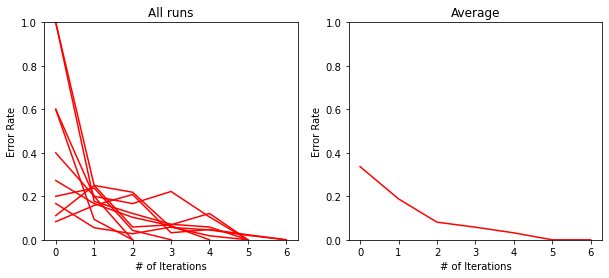

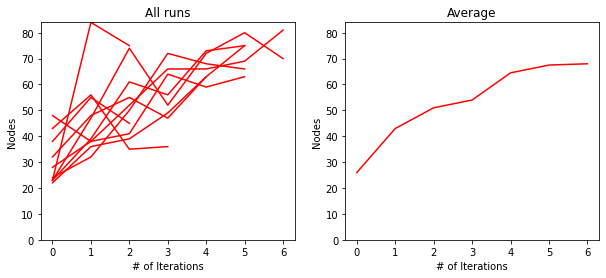

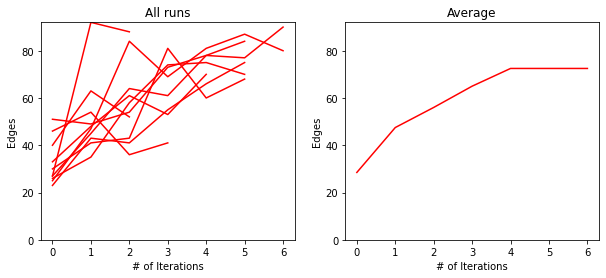

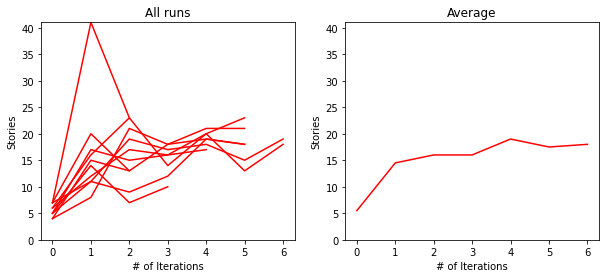

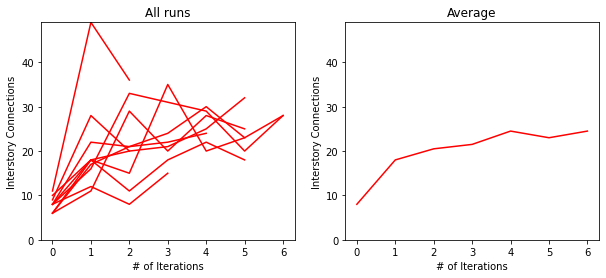

In [42]:
plot_all(all_iterations, all_percents, all_complexities)

## Add Node
Adding nodes and clustering.

### Miami + Florida

In [43]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
subset_query = query.loc[124:].astype({'id': 'int32'})
i = 0

while i < total_samples:
    print("===================================")
    print("Sample #" + str(i) + " (Valid Sample #" + str(len(all_complexities)) + ")")
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    drop = False
    while percent_filter > 0:
        G, graph_df, storylines = generate_map(query, dataset, k_input=8, start_nodes=[124], 
                                               previous_actions=previous_actions, verbose=False, 
                                               random_state=random_state, force_cluster=True, use_new_LP=True)
        
        all_relevant_nodes = subset_query[subset_query.title.str.contains('miami', case=False) 
                                                 | subset_query.title.str.contains('florida', case=False)]
        relevant_nodes = graph_df[graph_df.title.str.contains('miami', case=False) | 
                                   graph_df.title.str.contains('florida', case=False)]
        
        unselected_relevant_nodes = (all_relevant_nodes.merge(relevant_nodes, on=['id'], how='left', indicator=True)
                                     .query('_merge == "left_only"')
                                     .drop('_merge', 1))
        relevant_node_list = [str(node) for node in relevant_nodes.id.tolist()]
        # Select first 10% nodes.
        percentage = 10
        selected_nodes_df = unselected_relevant_nodes.head(int(len(unselected_relevant_nodes.index) * (percentage / 100)))
        selected_nodes_list = [str(node) for node in selected_nodes_df.id.tolist()]
        
        add_node = {"action": "add-node", "content": selected_nodes_list}
        previous_actions.append(add_node)
        
        # Mark nodes as part of the same cluster
        new_cluster = {"action": "add-cluster-list", "content": [relevant_node_list, 1]}
        previous_actions.append(new_cluster)
        
        # Are the relevant nodes connected?
        non_isolated_nodes = set()
        relevant_node_n = len(relevant_nodes)

        count_same_story = 0
        count_direct_connection = 0
        count_same_parent = 0
        count_same_children = 0
        count_has_path = 0
        for combination in itertools.combinations(relevant_node_list,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1

                
        print("# of Relevant Nodes: " + str(relevant_node_n))
        print("Same story " + str(count_same_story), 
              "Direct connection " + str(count_direct_connection), 
              "Same parent " + str(count_same_parent),
              "Same children " + str(count_same_children))
            
        if relevant_node_n == 0:
            percent_filter = 0.0
        else:
            percent_filter = 1 - len(non_isolated_nodes) / relevant_node_n
        
        if percent_filter == 0 and inner_iter_count == 0: 
            # if the map was perfect from the start, we will need more samples and we should drop this one.
            drop = True
            total_samples += 1
            
        percent_list.append(percent_filter)
        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter, add_node, "Relevant nodes: " + str(relevant_node_list))
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    
    i += 1
    actions = []
    for action in previous_actions:
        actions += action['content']
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0 (Valid Sample #0)
# of Relevant Nodes: 2
Same story 0 Direct connection 0 Same parent 0 Same children 0
Step: 1 1.0 {'action': 'add-node', 'content': ['170', '175', '181']} Relevant nodes: ['169', '250']
Complexity: [38, 40, 7, 7, 0, 9]
# of Relevant Nodes: 7
Same story 1 Direct connection 0 Same parent 0 Same children 0
Step: 2 0.7142857142857143 {'action': 'add-node', 'content': ['182', '186', '188']} Relevant nodes: ['169', '170', '175', '181', '250', '256', '370']
Complexity: [42, 49, 11, 7, 4, 18]
# of Relevant Nodes: 17
Same story 14 Direct connection 2 Same parent 1 Same children 7
Step: 3 0.0 {'action': 'add-node', 'content': ['212', '217']} Relevant nodes: ['169', '170', '175', '181', '182', '186', '188', '193', '197', '237', '250', '256', '370', '396', '402', '454', '460']
Complexity: [66, 70, 19, 14, 5, 23]
Sample #1 (Valid Sample #1)
# of Relevant Nodes: 3
Same story 1 Direct connection 1 Same parent 0 Same children 0
Step: 1 0.0 {'action': 'add-node', 'content': 

# of Relevant Nodes: 13
Same story 9 Direct connection 5 Same parent 4 Same children 9
Step: 4 0.0 {'action': 'add-node', 'content': ['188', '193']} Relevant nodes: ['169', '170', '175', '181', '182', '186', '237', '390', '396', '414', '429', '454', '460']
Complexity: [38, 47, 13, 9, 4, 22]
Sample #10 (Valid Sample #6)
# of Relevant Nodes: 8
Same story 6 Direct connection 1 Same parent 0 Same children 1
Step: 1 0.0 {'action': 'add-node', 'content': ['170', '175', '182']} Relevant nodes: ['169', '181', '223', '250', '305', '313', '320', '414']
Complexity: [22, 23, 7, 3, 4, 8]
Sample #11 (Valid Sample #6)
# of Relevant Nodes: 1
Same story 0 Direct connection 0 Same parent 0 Same children 0
Step: 1 1.0 {'action': 'add-node', 'content': ['169', '170', '175']} Relevant nodes: ['256']
Complexity: [23, 27, 7, 5, 2, 11]
# of Relevant Nodes: 4
Same story 0 Direct connection 1 Same parent 0 Same children 0
Step: 2 0.5 {'action': 'add-node', 'content': ['181', '182', '186']} Relevant nodes: ['169

In [44]:
results_clustering = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_add_florida_full.json', 'w') as fp:
    json.dump(results_clustering, fp)

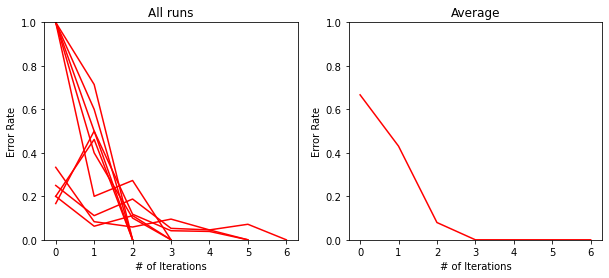

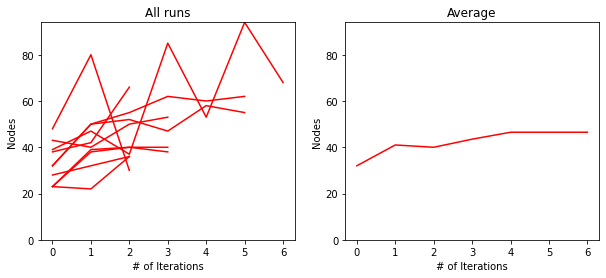

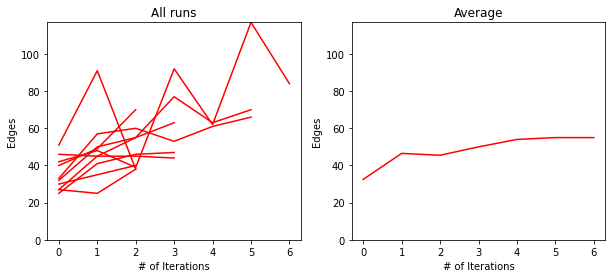

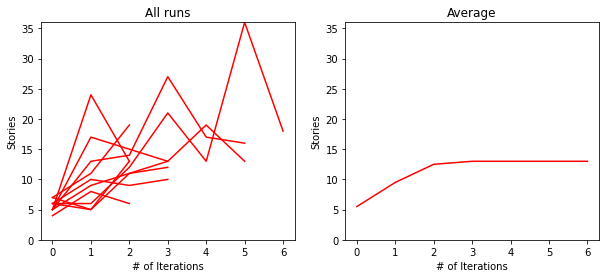

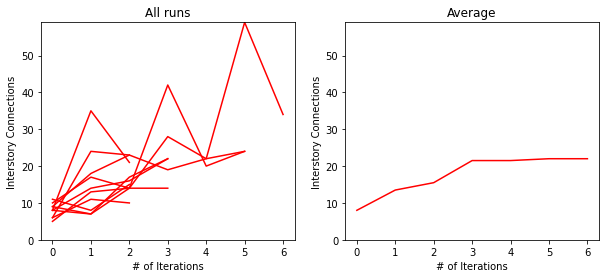

In [45]:
plot_all(all_iterations, all_percents, all_complexities)

### Biden

In [46]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
subset_query = query.loc[124:].astype({'id': 'int32'})
i = 0

while i < total_samples:
    print("===================================")
    print("Sample #" + str(i) + " (Valid Sample #" + str(len(all_complexities)) + ")")
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter = 1.0
    percent_list = []
    drop = False
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    
    while percent_filter > 0:
        G, graph_df, storylines = generate_map(query, dataset, k_input=8, start_nodes=[124], 
                                               previous_actions=previous_actions, verbose=False, 
                                               random_state=random_state, force_cluster=True, use_new_LP=True)
        
        all_relevant_nodes = subset_query[subset_query.title.str.contains('biden', case=False) 
                                                 | subset_query.title.str.contains('biden', case=False)]
        relevant_nodes = graph_df[graph_df.title.str.contains('biden', case=False) | 
                                   graph_df.title.str.contains('biden', case=False)]
        
        unselected_relevant_nodes = (all_relevant_nodes.merge(relevant_nodes, on=['id'], how='left', indicator=True)
                                     .query('_merge == "left_only"')
                                     .drop('_merge', 1))
        relevant_node_list = [str(node) for node in relevant_nodes.id.tolist()]
        # Select first 10% nodes.
        percentage = 10
        selected_nodes_df = unselected_relevant_nodes.head(int(len(unselected_relevant_nodes.index) * (percentage / 100)))
        selected_nodes_list = [str(node) for node in selected_nodes_df.id.tolist()]
        
        add_node = {"action": "add-node", "content": selected_nodes_list}
        previous_actions.append(add_node)
        
        # Mark nodes as part of the same cluster
        new_cluster = {"action": "add-cluster-list", "content": [relevant_node_list, 1]}
        previous_actions.append(new_cluster)
        
        # Are the relevant nodes connected?
        non_isolated_nodes = set()
        relevant_node_n = len(relevant_nodes)

        count_same_story = 0
        count_direct_connection = 0
        count_same_parent = 0
        count_same_children = 0
        count_has_path = 0
        for combination in itertools.combinations(relevant_node_list,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1
        
        print("# of Relevant Nodes: " + str(relevant_node_n))
        print("Same story " + str(count_same_story), 
              "Direct connection " + str(count_direct_connection), 
              "Same parent " + str(count_same_parent),
              "Same children " + str(count_same_children))
            
        if relevant_node_n == 0:
            percent_filter = 0.0
        else:
            percent_filter = 1 - len(non_isolated_nodes) / relevant_node_n
        
        if percent_filter == 0 and inner_iter_count == 0: 
            # if the map was perfect from the start, we will need more samples and we should drop this one.
            drop = True
            total_samples += 1
            
        percent_list.append(percent_filter)
        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter, add_node, "Relevant nodes: " + str(relevant_node_list))
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    
    i += 1
    actions = []
    for action in previous_actions:
        actions += action['content']
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0 (Valid Sample #0)
# of Relevant Nodes: 6
Same story 6 Direct connection 0 Same parent 0 Same children 0
Step: 1 0.33333333333333337 {'action': 'add-node', 'content': ['133', '140', '143', '148', '151', '156', '159', '166']} Relevant nodes: ['270', '276', '335', '337', '339', '435']
Complexity: [38, 40, 7, 7, 0, 9]
# of Relevant Nodes: 19
Same story 23 Direct connection 2 Same parent 2 Same children 2
Step: 2 0.052631578947368474 {'action': 'add-node', 'content': ['148', '156', '159', '168', '173', '179', '180']} Relevant nodes: ['133', '140', '143', '151', '166', '192', '217', '227', '270', '276', '335', '337', '339', '375', '377', '392', '435', '441', '450']
Complexity: [47, 47, 11, 9, 2, 11]
# of Relevant Nodes: 24
Same story 37 Direct connection 6 Same parent 4 Same children 5
Step: 3 0.16666666666666663 {'action': 'add-node', 'content': ['156', '159', '168', '173', '179', '183']} Relevant nodes: ['133', '140', '143', '148', '151', '166', '180', '192', '217', '227', '276',

# of Relevant Nodes: 47
Same story 80 Direct connection 19 Same parent 7 Same children 29
Step: 5 0.0 {'action': 'add-node', 'content': ['180', '184', '219', '221']} Relevant nodes: ['133', '140', '143', '148', '151', '156', '159', '166', '168', '173', '179', '183', '189', '192', '201', '210', '212', '217', '223', '226', '228', '256', '258', '259', '264', '267', '270', '276', '303', '331', '339', '342', '347', '349', '355', '371', '375', '377', '378', '392', '393', '421', '426', '441', '442', '443', '450']
Complexity: [73, 84, 18, 14, 4, 29]
Sample #7 (Valid Sample #4)
# of Relevant Nodes: 12
Same story 17 Direct connection 2 Same parent 1 Same children 0
Step: 1 0.0 {'action': 'add-node', 'content': ['133', '140', '143', '148', '151', '156', '159']} Relevant nodes: ['184', '201', '227', '267', '335', '339', '345', '405', '410', '426', '435', '441']
Complexity: [32, 33, 5, 5, 0, 6]
Sample #8 (Valid Sample #4)
# of Relevant Nodes: 7
Same story 5 Direct connection 1 Same parent 0 Same ch

# of Relevant Nodes: 39
Same story 30 Direct connection 20 Same parent 6 Same children 51
Step: 3 0.0 {'action': 'add-node', 'content': ['184', '189', '210', '212', '219']} Relevant nodes: ['133', '140', '143', '148', '151', '156', '159', '166', '168', '173', '179', '180', '183', '192', '201', '217', '223', '226', '227', '256', '259', '262', '267', '315', '331', '333', '339', '355', '371', '373', '375', '377', '392', '405', '435', '438', '450', '452', '484']
Complexity: [51, 57, 23, 10, 13, 29]
Sample #19 (Valid Sample #8)
# of Relevant Nodes: 7
Same story 5 Direct connection 0 Same parent 0 Same children 0
Step: 1 0.0 {'action': 'add-node', 'content': ['133', '140', '143', '148', '151', '156', '159', '166']} Relevant nodes: ['276', '337', '342', '405', '437', '440', '483']
Complexity: [38, 43, 7, 7, 0, 12]
Sample #20 (Valid Sample #8)
# of Relevant Nodes: 7
Same story 4 Direct connection 0 Same parent 0 Same children 0
Step: 1 0.2857142857142857 {'action': 'add-node', 'content': ['133

In [47]:
results_clustering = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_add_biden_full.json', 'w') as fp:
    json.dump(results_clustering, fp)

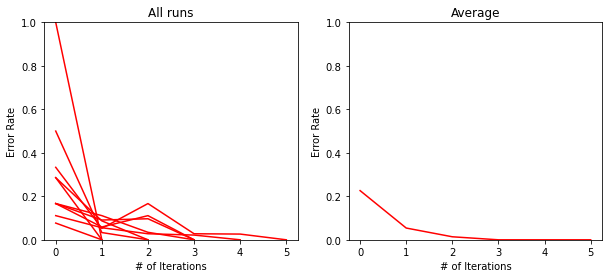

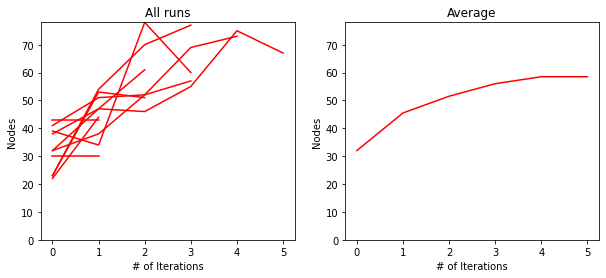

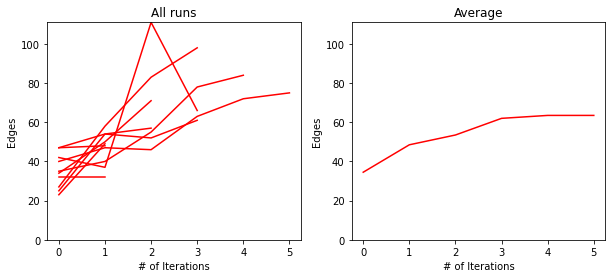

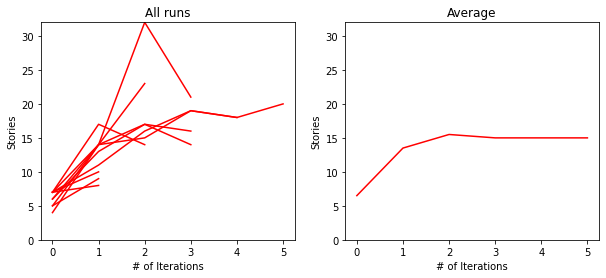

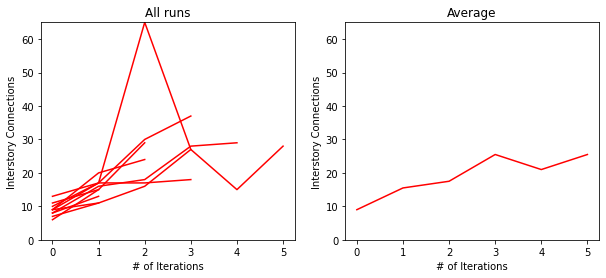

In [48]:
plot_all(all_iterations, all_percents, all_complexities)

## Generate Final Plot

In [49]:
f = open('results_delete_right_full.json')
results_delete_right = json.load(f)
f = open('results_delete_fox_bb_full.json')
results_delete_fox_bb = json.load(f)
f = open('results_delete_florida_full.json')
results_delete_florida = json.load(f)
f = open('results_delete_edges_full.json')
results_delete_edges = json.load(f)
f = open('results_consistent_story_full.json')
results_consistent_story = json.load(f)
f = open('results_clustering_bb_center_full.json')
results_clustering_bb_center = json.load(f)
f = open('results_clustering_florida_full.json')
results_clustering_florida = json.load(f)
f = open('results_add_florida_full.json')
results_add_florida = json.load(f)
f = open('results_add_biden_full.json')
results_add_biden = json.load(f)

In [60]:
def average_series(json_dict):
    all_iterations = json_dict['iterations']
    all_percents = json_dict['percents']
    max_iter = max(all_iterations)
    extended_percent_list = []
    for percent_list in all_percents:
        percent_list_extended = percent_list + [0 for _ in range(max_iter - len(percent_list))]
        extended_percent_list.append(percent_list_extended)
    extended_percent_array = np.array(extended_percent_list)
    average_percent = np.mean(extended_percent_array, axis=0)
    return average_percent

In [61]:
def generate_x_y(json_dict):
    y = average_series(json_dict)
    x = range(max(json_dict['iterations']))
    return x, y

In [62]:
average_percent = average_series(results_delete_right)
max_iter = max(results_delete_right['iterations'])

In [63]:
def average_metric(json_dict, column='Nodes'):
    all_iterations = json_dict['iterations']
    all_percents = [list(iteration[column].values()) for iteration in json_dict['complexity']]
    max_iter = max(all_iterations)
    extended_metric_list = []
    for idx, complexity in enumerate(all_percents):
        metric_list_extended = complexity + [complexity[-1] for _ in range(max_iter - len(complexity))]
        extended_metric_list.append(metric_list_extended)
    extended_metric_array = np.array(extended_metric_list)
    average_metric = np.nanmean(extended_metric_array, axis=0)
    return average_metric

In [64]:
heigth = 40
width = 32
plt.rcParams['figure.figsize'] = [heigth/2.54, width/2.54]
plt.rcParams.update({'font.size': 14})

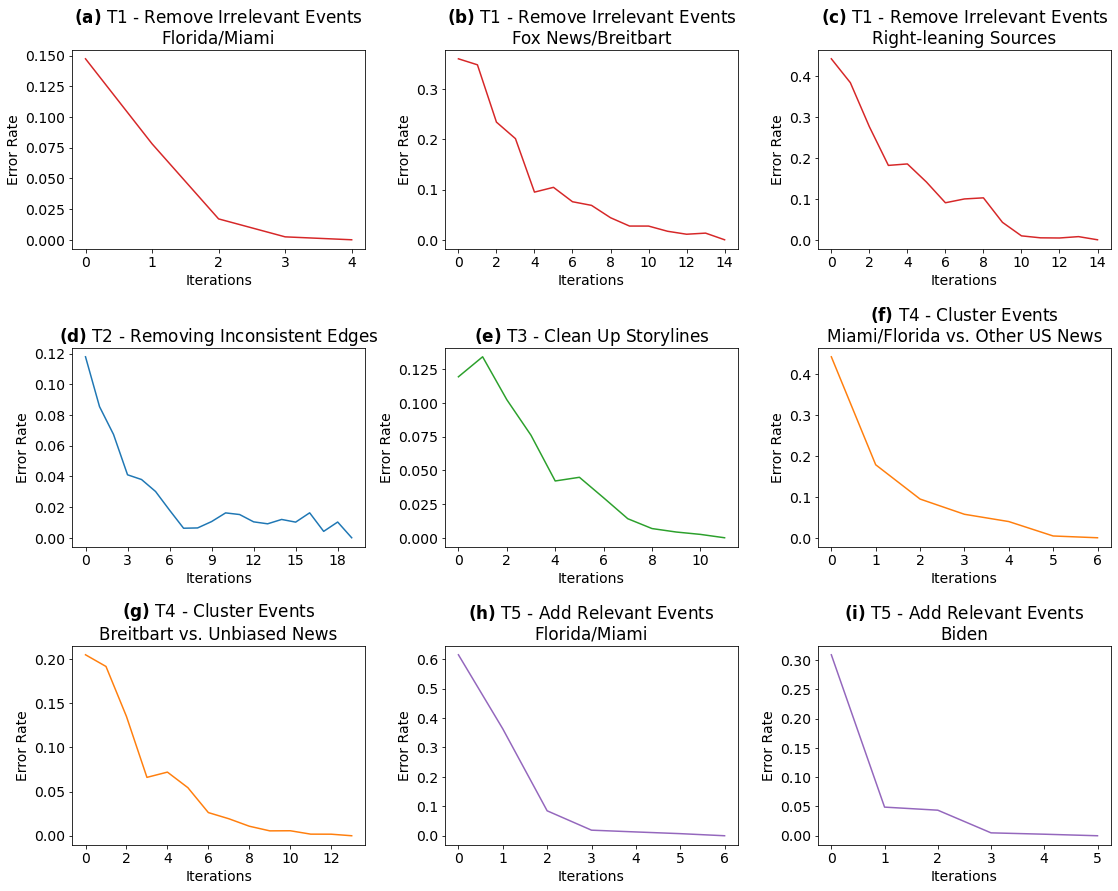

In [65]:
fig, axs = plt.subplots(3, 3)

x, y = generate_x_y(results_delete_florida)
axs[0, 0].plot(x, y, 'tab:red')
axs[0, 0].set_title(r'$\bf{(a)}$ ' + 'T1 - Remove Irrelevant Events\nFlorida/Miami')

x, y = generate_x_y(results_delete_fox_bb)
axs[0, 1].plot(x, y, 'tab:red')
axs[0, 1].set_title(r'$\bf{(b)}$ ' + 'T1 - Remove Irrelevant Events\nFox News/Breitbart')

x, y = generate_x_y(results_delete_right)
axs[0, 2].plot(x, y, 'tab:red')
axs[0, 2].set_title(r'$\bf{(c)}$ ' + 'T1 - Remove Irrelevant Events\nRight-leaning Sources')

x, y = generate_x_y(results_delete_edges)
axs[1, 0].plot(x, y, 'tab:blue')
axs[1, 0].set_title(r'$\bf{(d)}$ ' + 'T2 - Removing Inconsistent Edges')

x, y = generate_x_y(results_consistent_story)
axs[1, 1].plot(x, y, 'tab:green')
axs[1, 1].set_title(r'$\bf{(e)}$ ' + 'T3 - Clean Up Storylines')

x, y = generate_x_y(results_clustering_florida)
axs[1, 2].plot(x, y, 'tab:orange')
axs[1, 2].set_title(r'$\bf{(f)}$ ' + 'T4 - Cluster Events\nMiami/Florida vs. Other US News')

x, y = generate_x_y(results_clustering_bb_center)
axs[2, 0].plot(x, y, 'tab:orange')
axs[2, 0].set_title(r'$\bf{(g)}$ ' + 'T4 - Cluster Events\nBreitbart vs. Unbiased News')

x, y = generate_x_y(results_add_florida)
axs[2, 1].plot(x, y, 'tab:purple')
axs[2, 1].set_title(r'$\bf{(h)}$ ' + 'T5 - Add Relevant Events\nFlorida/Miami')

x, y = generate_x_y(results_add_biden)
axs[2, 2].plot(x, y, 'tab:purple')
axs[2, 2].set_title(r'$\bf{(i)}$ ' + 'T5 - Add Relevant Events\nBiden')

for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel='Error Rate')

fig.tight_layout()
# Hide x labels and tick labels for top plots and y ticks for right plots.
from matplotlib.ticker import MaxNLocator
for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.label_outer()

In [68]:
fig.savefig('results_simu_full.pdf')

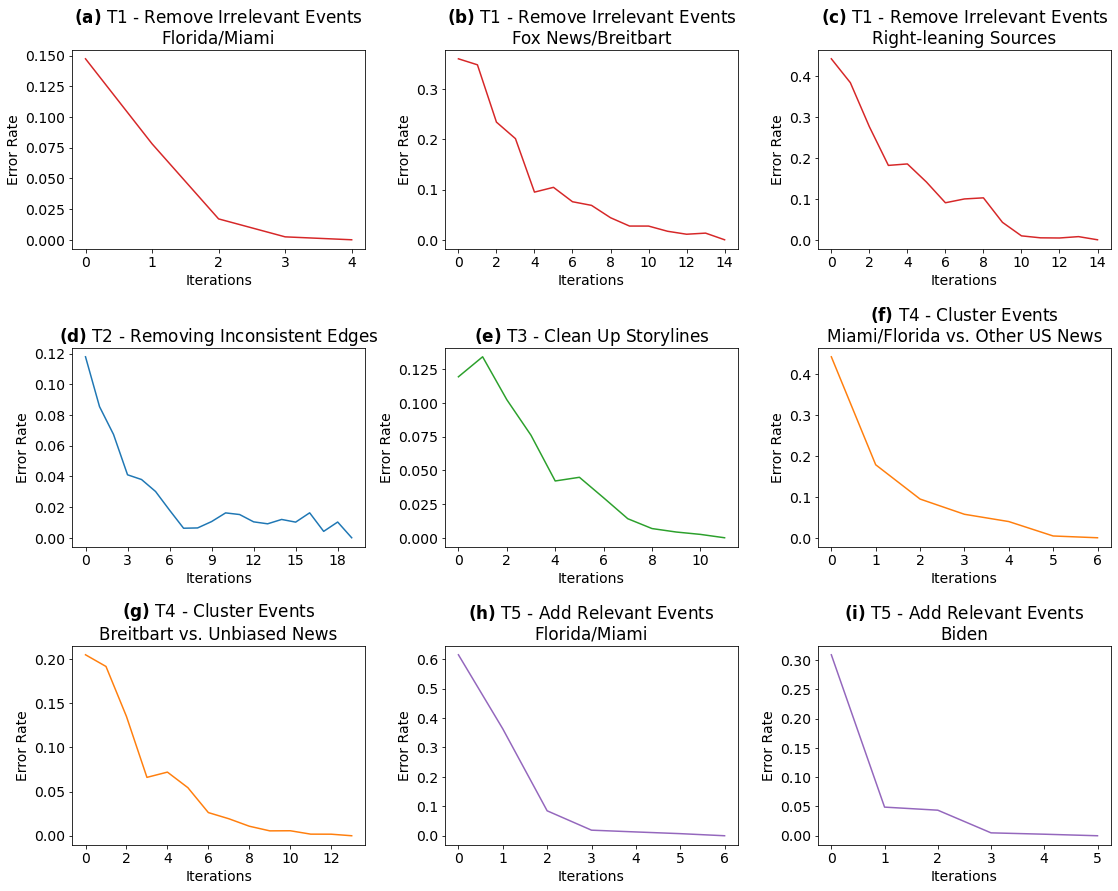

In [66]:
heigth = 40
width = 32
plt.rcParams['figure.figsize'] = [heigth/2.54, width/2.54]
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(3, 3)

x, y = generate_x_y(results_delete_florida)
axs[0, 0].plot(x, y, 'tab:red')
axs[0, 0].set_title(r'$\bf{(a)}$ ' + 'T1 - Remove Irrelevant Events\nFlorida/Miami')

x, y = generate_x_y(results_delete_fox_bb)
axs[0, 1].plot(x, y, 'tab:red')
axs[0, 1].set_title(r'$\bf{(b)}$ ' + 'T1 - Remove Irrelevant Events\nFox News/Breitbart')

x, y = generate_x_y(results_delete_right)
axs[0, 2].plot(x, y, 'tab:red')
axs[0, 2].set_title(r'$\bf{(c)}$ ' + 'T1 - Remove Irrelevant Events\nRight-leaning Sources')

x, y = generate_x_y(results_delete_edges)
axs[1, 0].plot(x, y, 'tab:blue')
axs[1, 0].set_title(r'$\bf{(d)}$ ' + 'T2 - Removing Inconsistent Edges')

x, y = generate_x_y(results_consistent_story)
axs[1, 1].plot(x, y, 'tab:green')
axs[1, 1].set_title(r'$\bf{(e)}$ ' + 'T3 - Clean Up Storylines')

x, y = generate_x_y(results_clustering_florida)
axs[1, 2].plot(x, y, 'tab:orange')
axs[1, 2].set_title(r'$\bf{(f)}$ ' + 'T4 - Cluster Events\nMiami/Florida vs. Other US News')

x, y = generate_x_y(results_clustering_bb_center)
axs[2, 0].plot(x, y, 'tab:orange')
axs[2, 0].set_title(r'$\bf{(g)}$ ' + 'T4 - Cluster Events\nBreitbart vs. Unbiased News')

x, y = generate_x_y(results_add_florida)
axs[2, 1].plot(x, y, 'tab:purple')
axs[2, 1].set_title(r'$\bf{(h)}$ ' + 'T5 - Add Relevant Events\nFlorida/Miami')

x, y = generate_x_y(results_add_biden)
axs[2, 2].plot(x, y, 'tab:purple')
axs[2, 2].set_title(r'$\bf{(i)}$ ' + 'T5 - Add Relevant Events\nBiden')

for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel='Error Rate')

fig.tight_layout()
# Hide x labels and tick labels for top plots and y ticks for right plots.
from matplotlib.ticker import MaxNLocator
for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.label_outer()